# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [ ]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [ ]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = {"username":"damieu","key":"a012f3a537bfcb2efd84b9ff36bba697"}

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [ ]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [ ]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Download complete!


In [ ]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Data re-split complete. New dataset location: chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [ ]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

In [ ]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################


# Inputs Analysis
# Initialize Variables
inputs_path = "chest_xray_dataset_new_split"
image_resolutions = []
image_means = []
image_stds = []
max_mean = 0
max_mean_img = None
min_mean = 500
min_mean_img = None
max_std = 0
max_std_img = None
min_std = 500
min_std_img = None

# Loop through all splits
for split in splits:
    # loop through each class in each split
    for cls in classes:
        path = os.path.join(inputs_path, split, cls)
        # loop through each image in each split and gather information
        for img in os.listdir(path):
            img_file = os.path.join(path, img)
            with Image.open(img_file) as img:
                # gather image resolutions before resize and crop
                image_resolutions.append(img.size)

                # resize images for mean and std calculations
                img = transforms.Resize(256)(img)
                # center crop images
                img = transforms.CenterCrop(256)(img)

                # calculate means and stds
                image_means.append(np.array(img).mean())
                image_stds.append(np.array(img).std())

                if np.array(img).mean() > max_mean:
                    max_mean = np.array(img).mean()
                    max_mean_img = img_file
                if np.array(img).mean() < min_mean:
                    min_mean = np.array(img).mean()
                    min_mean_img = img_file
                if np.array(img).std() > max_std:
                    max_std = np.array(img).std()
                    max_std_img = img_file
                if np.array(img).std() < min_std:
                    min_std = np.array(img).std()
                    min_std_img = img_file

           train  val  test  total
NORMAL      1266  158   159   1583
PNEUMONIA   3418  427   428   4273


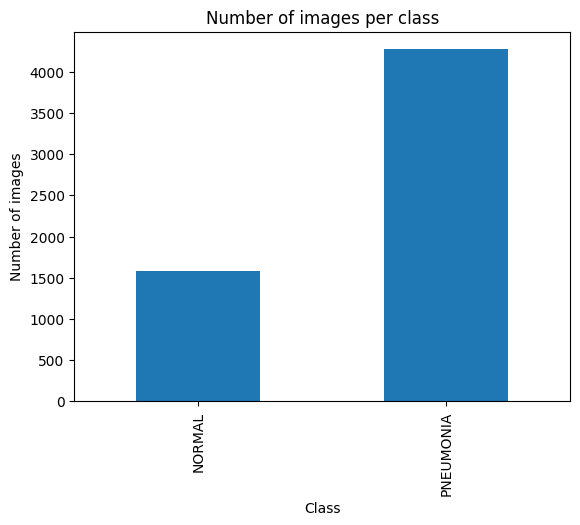

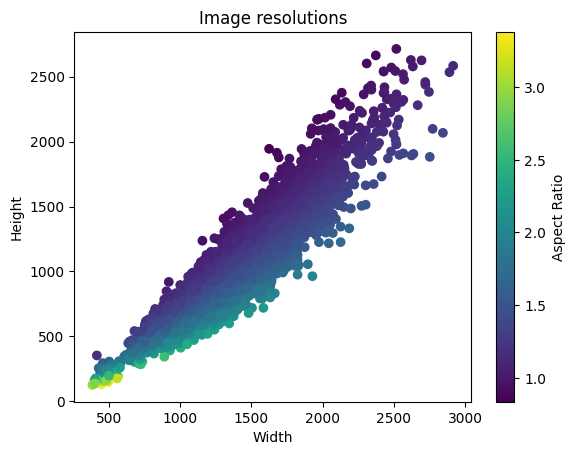

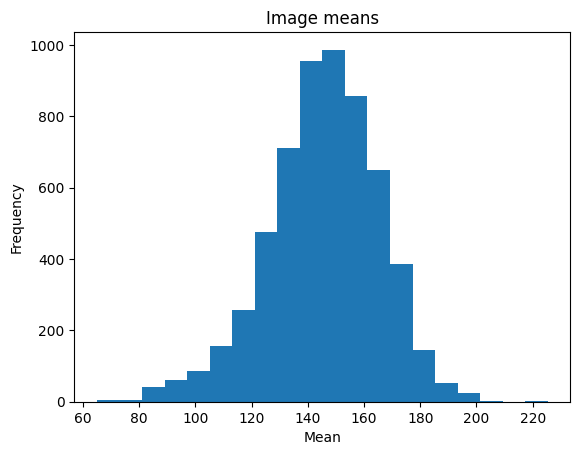

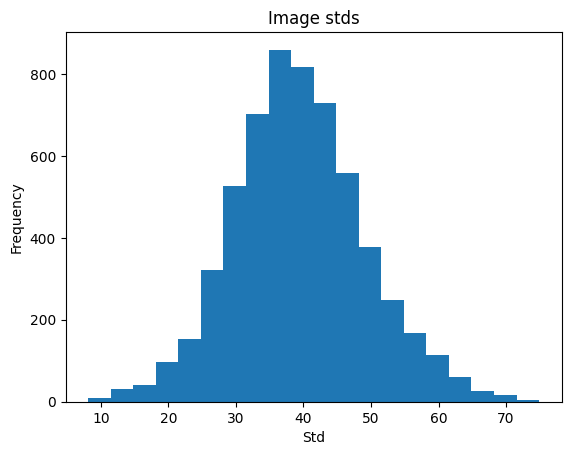

Image with highest mean:


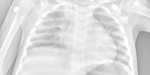

Image with lowest mean:


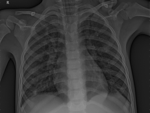

Image with highest std:


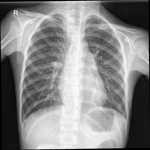

Image with lowest std:


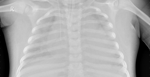

Mean of image values across dataset 0.5685602532078823
Mean of std of image values across dataset 0.15386388983938462


In [ ]:
# Labels analysis
import pandas as pd
# Convert into a dataframe and then sum over splits to get total
df = pd.DataFrame(stats)
df['total'] = df.sum(axis=1)
print(df)
# Create a bar chart of label distribution
df['total'].plot(kind='bar')
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

aspect_ratios = [res[0] / res[1] for res in image_resolutions]
# Plot all image resolutions
plt.scatter(*zip(*image_resolutions),c=aspect_ratios, cmap='viridis')
plt.colorbar(label='Aspect Ratio')
plt.title('Image resolutions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Means histogram
plt.hist(image_means, bins=20)
plt.title('Image means')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.show()

# Stds histogram
plt.hist(image_stds, bins=20)
plt.title('Image stds')
plt.xlabel('Std')
plt.ylabel('Frequency')
plt.show()


# Display the images with the highest and lowest means
# Define the maximum display size, with aspect ratio preserved
display_size = (150, 150)  # Maximum width and height

# Open and resize images while preserving aspect ratio
max_mean_img_resized = Image.open(max_mean_img)
max_mean_img_resized.thumbnail(display_size)

min_mean_img_resized = Image.open(min_mean_img)
min_mean_img_resized.thumbnail(display_size)

# Display the images
print("Image with highest mean:")
display(max_mean_img_resized)
print("Image with lowest mean:")
display(min_mean_img_resized)

max_std_img_resized = Image.open(max_std_img)
max_std_img_resized.thumbnail(display_size)

min_std_img_resized = Image.open(min_std_img)
min_std_img_resized.thumbnail(display_size)

# Display the images
print("Image with highest std:")
display(max_std_img_resized)
print("Image with lowest std:")
display(min_std_img_resized)

np_image_means = np.array(image_means)
np_image_stds = np.array(image_stds)

print(f"Mean of image values across dataset {np_image_means.mean()/256}")
print(f"Mean of std of image values across dataset {np_image_stds.mean()/256}")
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

**(a)**

It is clear that there is a label imbalance in the dataset and as such training could favour the pneumonia label and create a model that overpredicts for pneumonia. The inputs themselves contain a wide range of resolutions and aspect ratios which means some additional preprocessing beyond a simple image resize will be required such as padding or cropping which could add additional noise and slow down convergence if done improperly. The images also vary in mean and standard deviation requiring normalization in the data preparation which could cause a loss in definition with outlier images as compared to images with closer means and standard deviations to the average.

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [ ]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 64

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        # add images and labels from root dir
        self.images = []
        self.labels = []
        for cls in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(root_dir, split, cls)
            for img in os.listdir(path):
                self.images.append(os.path.join(path, img))
                self.labels.append(0 if cls == 'NORMAL' else 1)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(Image.open(image).convert('L'))
        return image, label

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
data_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize the shorter side to 256 while keeping aspect ratio
    transforms.CenterCrop(256),  # Center-crop to 256x256
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=0.5685602532078823, std=0.1538638898393846)  # Normalize using average mean and std of cropped images
])
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

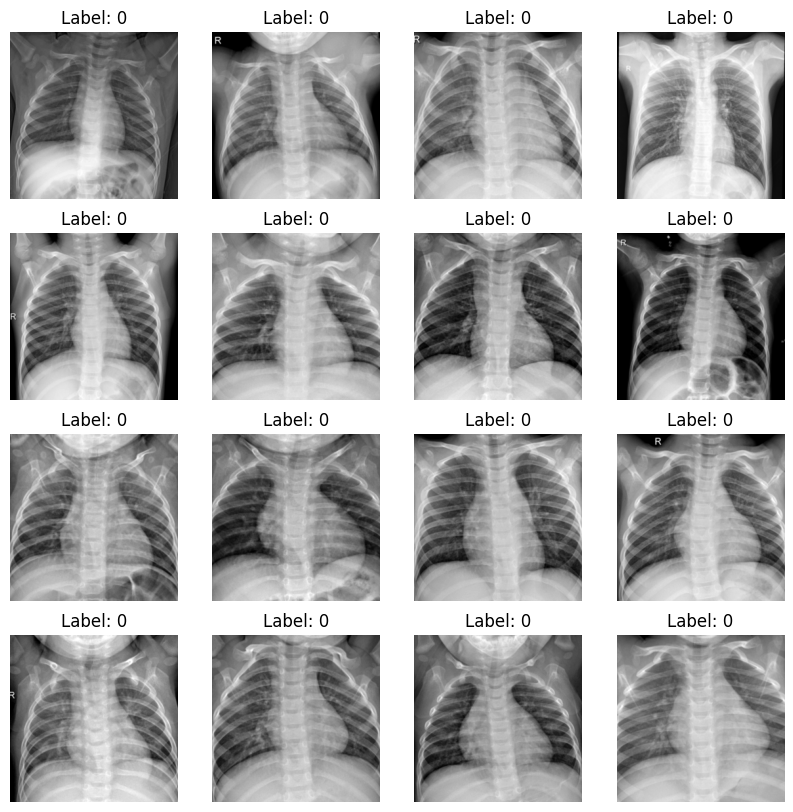

Train dataset size: 4684
Validation dataset size: 585
Test dataset size: 587
Batch of images shape: torch.Size([64, 1, 256, 256])
Batch of labels shape: torch.Size([64])


In [ ]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
# Create datasets
train_dataset = ChestXrayDataset(root_dir=dataset_path, split='train', transform=data_transforms)
val_dataset = ChestXrayDataset(root_dir=dataset_path, split='val', transform=data_transforms)
test_dataset = ChestXrayDataset(root_dir=dataset_path, split='test', transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# display 16 images from train_loader
images, labels = next(iter(train_loader))
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    axs[i // 4, i % 4].imshow(images[i].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(f"Label: {labels[i]}")
    axs[i // 4, i % 4].axis('off')
plt.show()

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Print batch shapes
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

**(a)**

The design decisions fall mostly into the data transforms to be applied to each of the images. As the images are quite high resolution I have resized them to be 256x256. This is done by first using the `transforms.Resize(256)` which maintains the aspect ratio of the image but shrinks it such that the smaller side is now 256 pixels tall or wide. The images also vary in their aspect ratios, as such I have used a simple `transforms.CenterCrop(256)` to crop the image around the centre into a 256x256 image. I then normalize the images to the averages of the mean and standard deviation of the values across the dataset. It is important to note that I crop the images in the same manner before calculating the mean and standard deviation as the normalize transform is performed after the image is cropped. This is done because some images' brightness is a clear outlier or they lack in contrast or both. Normalization allows for the dataset to be far more uniform allowing for smoother training. The training loader shuffles the data to focus learning on the general distribution of the data wihtout possibly incorporating any ordering. The other data loaders have been left unshuffled as to make results much more comparable.

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [ ]:
num_epochs = 20
use_wandb = False  # Set to True if you want to use wandb
lr = 0.001

In [ ]:
# Define the model
class SimpleModel(nn.Module):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        def __init__(self):
            super().__init__()
            # Define the layers of the model
            self.layers = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.Linear(64 * 64 * 32, 1),
            )


        def forward(self, x):
            return self.layers(x)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [ ]:
def calculate_class_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    #for each class get the number of true predictions and divide by total amount of that class
    correct = np.zeros(2)
    total = np.zeros(2)

    for i in range(len(labels)):
      if outputs[i] == labels[i]:
        correct[labels[i]] += 1
      total[labels[i]] += 1

    return [c/t for c,t in zip(correct,total)]
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    if use_wandb:
        wandb.init(project='chest_xray_classification-singleout')

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    train_class_accuracies = []
    val_class_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        # Initialize tracking variables for training
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        ep_predictions = []
        ep_labels = []
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training metrics
            train_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            ep_predictions.append(predicted)
            ep_labels.append(labels)



            if use_wandb:
                wandb.log({"train_loss": loss.item()})

        # Calculate training metrics for the epoch
        epoch_train_loss = train_loss / train_total
        epoch_train_accuracy = train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        ep_predictions = [pred for sublist in ep_predictions for pred in sublist]
        ep_labels = [label for sublist in ep_labels for label in sublist]
        train_class_accuracies.append(calculate_class_accuracy(ep_predictions, ep_labels))

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_ep_predictions = []
        val_ep_labels = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))

                # Accumulate validation metrics
                val_loss += loss.item() * inputs.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels.float()).sum().item()
                val_ep_predictions.append(predicted)
                val_ep_labels.append(labels)

                if use_wandb:
                    wandb.log({"val_loss": loss.item()})

        # Calculate validation metrics for the epoch
        epoch_val_loss = val_loss / val_total
        epoch_val_accuracy = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        val_ep_predictions = [pred for sublist in val_ep_predictions for pred in sublist]
        val_ep_labels = [label for sublist in val_ep_labels for label in sublist]
        val_class_accuracies.append(calculate_class_accuracy(val_ep_predictions, val_ep_labels))

# Feel free to add more intermediate functions to do this

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False, wandb_name = 'chest_xray_classification', scheduler = None):
    if use_wandb:
        wandb.init(project=wandb_name)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    train_class_accuracies = []
    val_class_accuracies = []


    for epoch in range(num_epochs):
        model.train()

        # Initialize tracking variables for training
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        ep_predictions = []
        ep_labels = []
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training metrics
            train_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    train_correct += 1
            train_total += labels.size(0)
            ep_predictions.append(predicted)
            ep_labels.append(labels)

            if use_wandb:
                wandb.log({"train_loss": loss.item()})
                wandb.log({"train_accuracy": train_correct / train_total})

        # Calculate training metrics for the epoch
        epoch_train_loss = train_loss / train_total
        epoch_train_accuracy = train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Calculate class accuracies (assuming this function is correct)
        ep_predictions_flat = [pred for sublist in ep_predictions for pred in sublist]
        ep_labels_flat = [label for sublist in ep_labels for label in sublist]
        train_class_accuracies.append(calculate_class_accuracy(ep_predictions_flat, ep_labels_flat))

        # Step scheduler if it exists
        if scheduler is not None:
            scheduler.step()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_ep_predictions = []
        val_ep_labels = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))

                # Accumulate validation metrics
                val_loss += loss.item() * inputs.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                for i in range(len(predicted)):
                    if predicted[i] == labels[i]:
                        val_correct += 1
                val_ep_predictions.append(predicted)
                val_ep_labels.append(labels)

                if use_wandb:
                    wandb.log({"val_loss": loss.item()})
                    wandb.log({"val_accuracy": val_correct / val_total})

        # Calculate validation metrics for the epoch
        epoch_val_loss = val_loss / val_total
        epoch_val_accuracy = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Calculate class accuracies for validation
        val_ep_predictions_flat = [pred for sublist in val_ep_predictions for pred in sublist]
        val_ep_labels_flat = [label for sublist in val_ep_labels for label in sublist]
        val_class_accuracies.append(calculate_class_accuracy(val_ep_predictions_flat, val_ep_labels_flat))

    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import torch

def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, model, train_loader, val_loader):
    # Initialize the main figure with subplots for training/validation metrics
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Plot losses
    axs[0, 0].plot(train_losses, label='Train Loss')
    axs[0, 0].plot(val_losses, label='Val Loss')
    axs[0, 0].set_title('Losses')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot accuracies
    axs[0, 1].plot(train_accuracies, label='Train Accuracy')
    axs[0, 1].plot(val_accuracies, label='Val Accuracy')
    axs[0, 1].set_title('Accuracies')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Training class accuracies
    train_normal_acc = [acc[0] for acc in train_class_accuracies]
    train_pneumonia_acc = [acc[1] for acc in train_class_accuracies]
    axs[1, 0].plot(train_normal_acc, label='Normal Accuracy')
    axs[1, 0].plot(train_pneumonia_acc, label='Pneumonia Accuracy')
    axs[1, 0].set_title('Training Class Accuracies')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    # Validation class accuracies
    val_normal_acc = [acc[0] for acc in val_class_accuracies]
    val_pneumonia_acc = [acc[1] for acc in val_class_accuracies]
    axs[1, 1].plot(val_normal_acc, label='Normal Accuracy')
    axs[1, 1].plot(val_pneumonia_acc, label='Pneumonia Accuracy')
    axs[1, 1].set_title('Validation Class Accuracies')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    # ROC Curve for training data
    train_preds = []
    train_labels = []
    train_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            train_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
    train_auc = auc(train_fpr, train_tpr)
    axs[0, 2].plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.2f}')
    axs[0, 2].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0, 2].set_title('Train ROC Curve')
    axs[0, 2].set_xlabel('False Positive Rate')
    axs[0, 2].set_ylabel('True Positive Rate')
    axs[0, 2].legend()

    # ROC Curve for validation data
    val_preds = []
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)
    val_auc = auc(val_fpr, val_tpr)
    axs[1, 2].plot(val_fpr, val_tpr, label=f'Val AUC = {val_auc:.2f}')
    axs[1, 2].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[1, 2].set_title('Validation ROC Curve')
    axs[1, 2].set_xlabel('False Positive Rate')
    axs[1, 2].set_ylabel('True Positive Rate')
    axs[1, 2].legend()

    # Adjust layout for main plots
    plt.tight_layout()
    plt.show()

    # Plot training confusion matrix
    train_cm = confusion_matrix(train_labels, train_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    train_cm_display = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Normal', 'Pneumonia'])
    train_cm_display.plot(ax=ax, colorbar=False)
    plt.title('Training Data Confusion Matrix')
    plt.show()

    # Plot validation confusion matrix
    val_cm = confusion_matrix(val_labels, val_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    val_cm_display = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=['Normal', 'Pneumonia'])
    val_cm_display.plot(ax=ax, colorbar=False)
    plt.title('Validation Data Confusion Matrix')
    plt.show()

Epoch 20/20 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


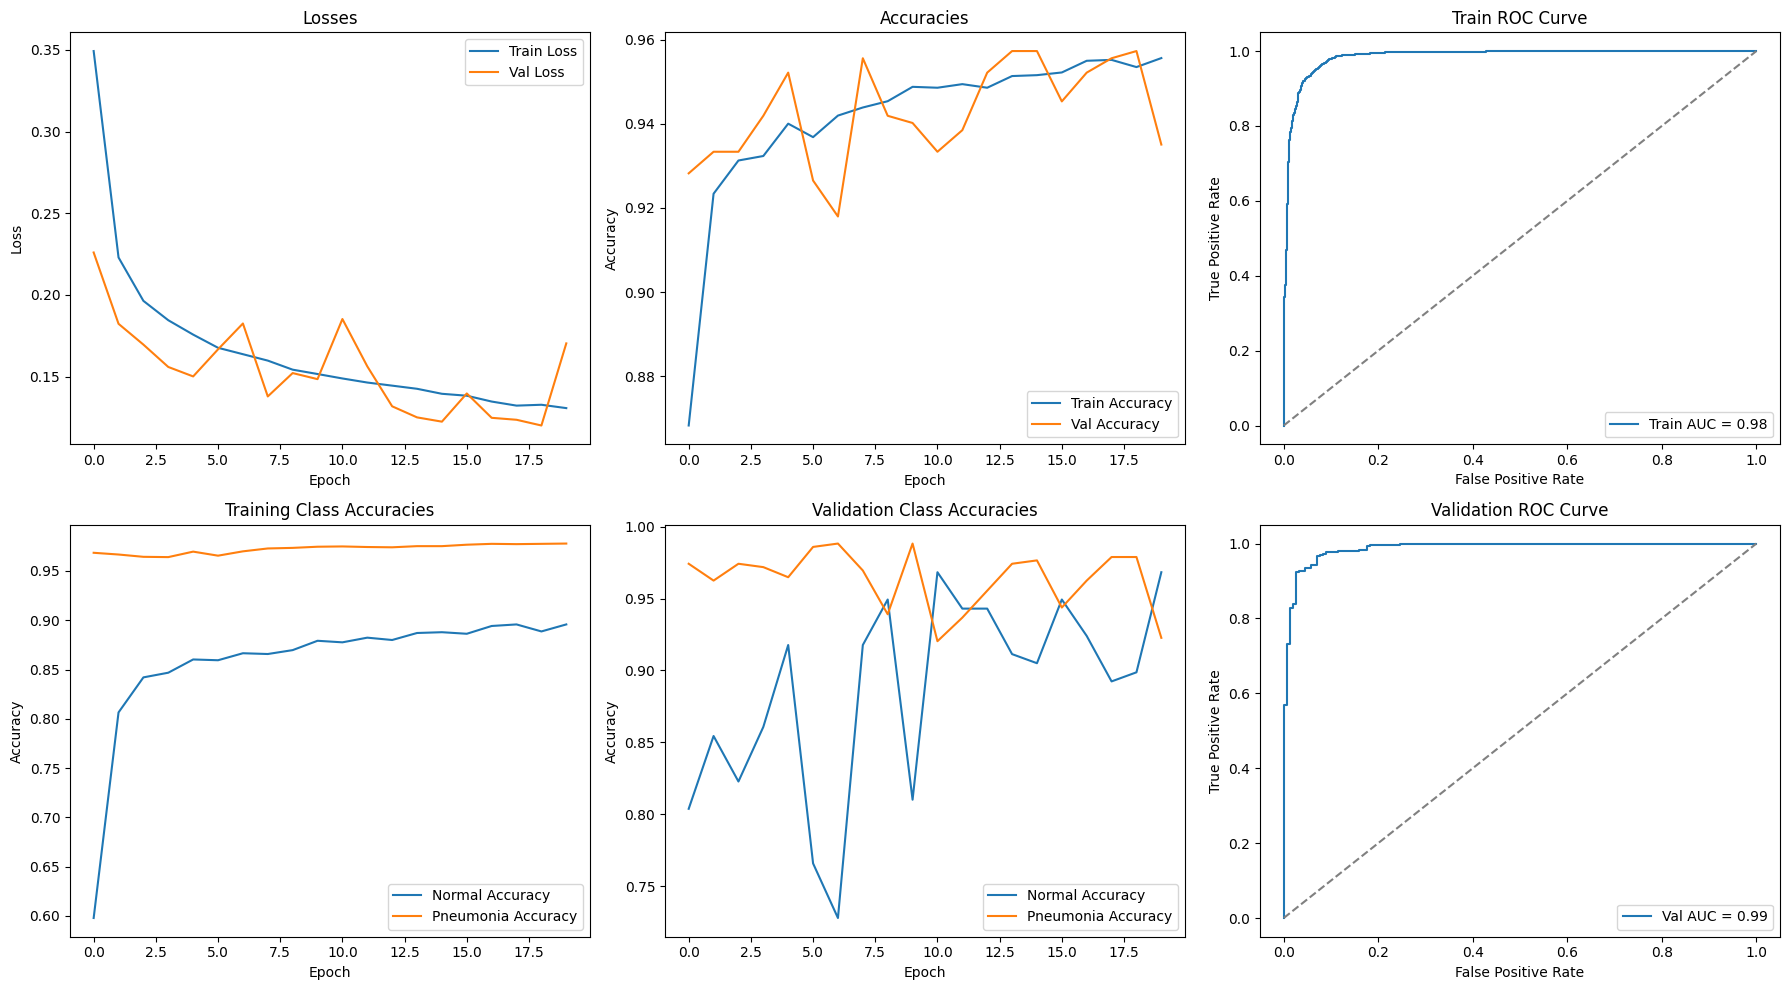

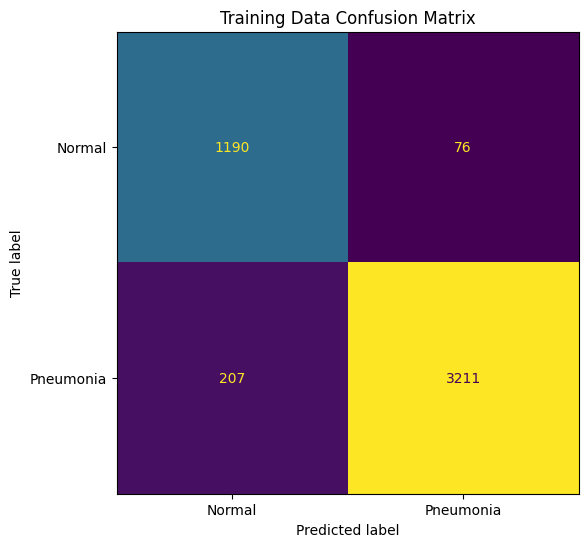

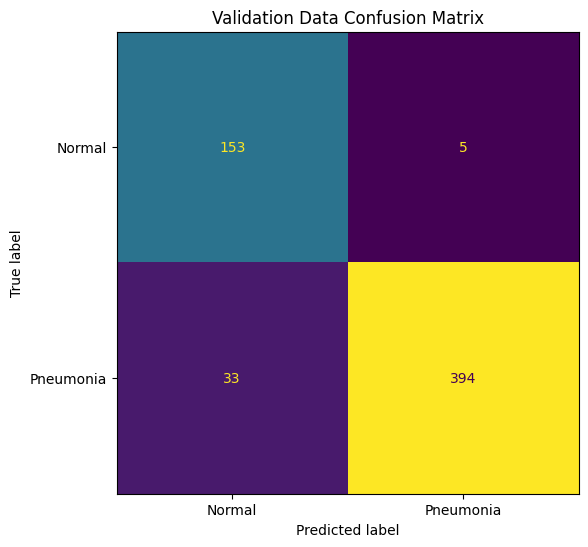

Model saved as 'chest_xray_model.pth'


In [ ]:
# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, model, train_loader, val_loader)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

**(a)**

I chose to make a simple CNN as it is the standard for image classification and is extremely quick to implement and train due to a low parameter count. CNNs are used for image classification over other simpler architectures such as MLPs because they are able to incorporate spatial context that linear models are not able to take into account. As such features can be extracted in a more information rich way than linear models while remaining much lighter. Within the model I have two convolutional layers with ReLU activation functions, max pooling and a final linear layer mapping directly to a single probability representing confidence in predicting pneumonia. Only having two convolutional layers keeps the model lightweight to allow for quicker training and to prevent an overly complex model which could cause overfitting. I chose ReLU activation as it is the most commonly used activation function for image classification. This allows for more exploration of less common activation functions to try in my improved baseline. I use max pooling to reduce the spatial dimensions in the simplest way. I reduce the dimensions so that convolutional layers are extracting more abstract features from the image after extracting initial detailed features. This also reduces the required size of the final fully connected layer which would grow massively in parameter count if using a full 256x256 image. I use BCE loss as it is the standard loss function for binary classification and its incorporation of model certainty in predictions. I use the `nn.BCEWithLogitsLoss()` class because it improves numerical stability by combining the sigmoid activation function with the BCE loss classification. I am using SGD for optimization because it is extremely simple and outperformed Adam in my testing. It does converge slightly slower however it was much more stable and generalizable than Adam. I use a learning rate of 0.001 which I settled on after testing various learning rates between 0.01 and 0.0001. A learning rate of 0.001 had the best balance of stability and speed of convergence.


**(b)**

 The below graphs depict the average loss, accuracy, and class accuracy at each epoch for the training and validation sets. These indicate the quality of the model's trainging progression and allow for a better understanding of how we can improve. The ROC curves are useful for assessing the quality of the final model by showing false and true positive rate as it relates to change in threshold for dictating whether a prediction is positive or negative. This indicates how confident the model is in its predictions with the ideal being an AUC score of 1 where false positives only appear at extremely low thresholds.

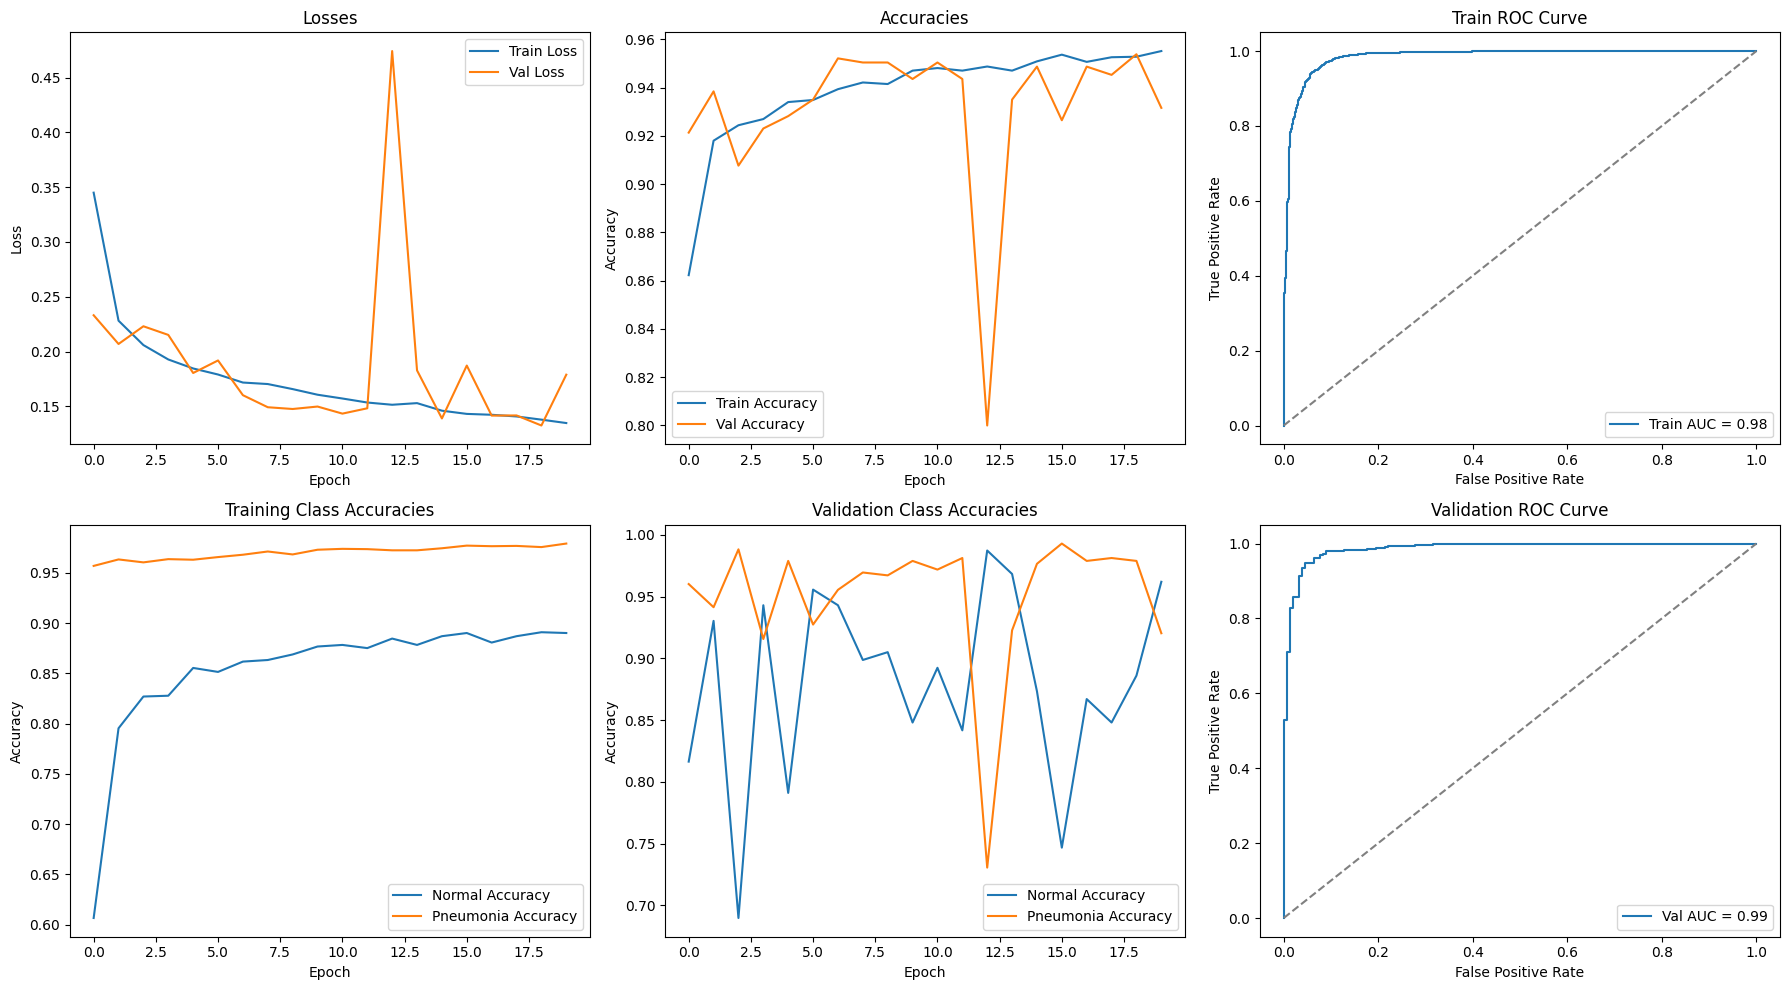

**(c)**

The model performs quite well but has some flaws to be improved upon. The most obvious is the difference in accuracy between the two classes. The class accuracy graph on the training data shows a clear gap of roughly 5-10% between the normal and pneumonia accuracies. A similar phenomenon can be seen in the validation set, however the accuracies are much noisier. Convergence is relatively quick and somewhat smooth achieving a relatively strong model after two epochs. There is a notable spike halfway during training which indicates a lack of stability in the training and potential for overfitting. Aside from the spike the model shows very few signs of overfitting. The validation metrics quite closely follow the training set metrics apart from class accuracies. Here the validation class accuracies were very unstable while the training class accuracies remained very stable. This could be indicative of some overfitting. Having unseen data likely reduces the confidence of the model in its predictions and as such pushes probabilities closer to the middle. The most uncertain predictions could then easily switch over to the opposite class. This is less of a concern when looking at the ROC curve of the final model on the validation set. Here the model performs extremely well with an AUC of 0.99 which indicates a strong ability to distinguish between positive an negative cases overall.

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

Epoch 20/20 - Validation: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


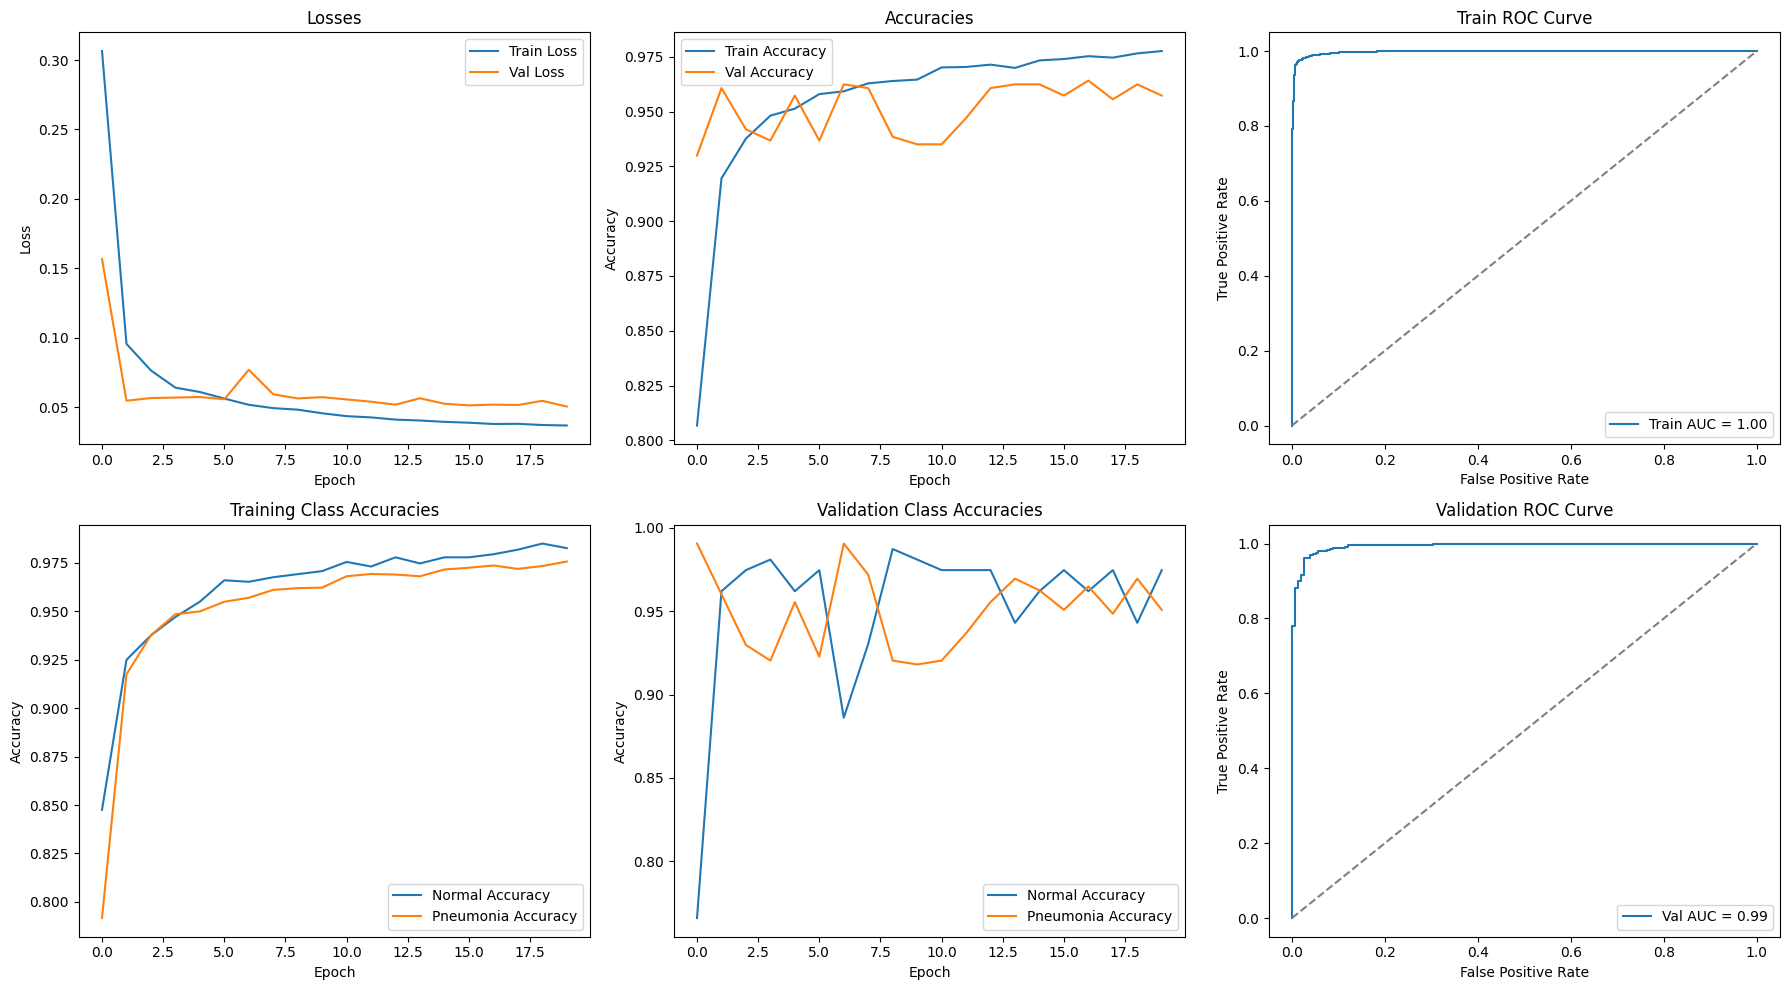

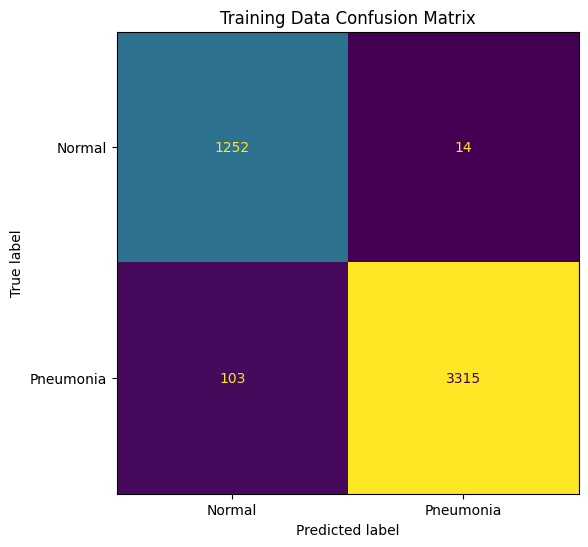

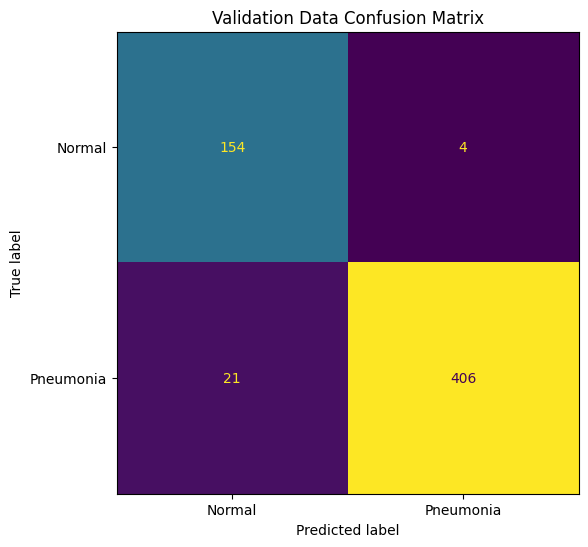

Training data: Mean:0.6911934018135071 StDev: 0.4174848794937134
Validation data: Mean:0.6841053366661072 StDev: 0.4163738489151001
Model saved as 'allimp_chest_xray_model.pth'


In [ ]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################
# Define the model
class ImprovedModel(nn.Module):

        def __init__(self):
            super().__init__()
            # Define the layers of the model
            self.layers = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16), # added batch normalization
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten(),
                nn.Linear(64 * 64 * 32, 1),
            )


        def forward(self, x):
            return self.layers(x)

# Initialize the model
model = ImprovedModel().to(device)

# Weight the loss by class

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.3]).to(device))

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, use_wandb=True, wandb_name='improved_chest_xray_classification', scheduler=scheduler)

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, model, train_loader, val_loader,)

# Save the model
torch.save(model.state_dict(), 'allimp_chest_xray_model.pth')
print("Model saved as 'allimp_chest_xray_model.pth'")


In [ ]:
torch.save(model.state_dict(), 'allimp_chest_xray_model.pth')
print("Model saved as 'allimp_chest_xray_model.pth'")

Model saved as 'allimp_chest_xray_model.pth'


In [ ]:
#evaluate model on test data
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_predictions = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        test_total += labels.size(0)
        for i in range(len(predicted)):
            if predicted[i] == labels[i]:
                test_correct += 1
        test_predictions.append(predicted)
        test_labels.append(labels)
        # Calculate test metrics
    test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_predictions = [pred for sublist in test_predictions for pred in sublist]
    test_labels = [label for sublist in test_labels for label in sublist]
    test_class_accuracy = calculate_class_accuracy(test_predictions, test_labels)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Class Accuracy: {test_class_accuracy}")

Test Loss: 0.0965, Test Accuracy: 0.9319, Test Class Accuracy: [0.9308176100628931, 0.9322429906542056]


**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*

**Batch Normalization**

Batch normalization works by recentering the activations of each layer around a mean of 0 and forcing it into a standard deviation of 1. The goal behind this is to increase the training speed and improve the stability of training. When looking at the baseline model some of the issues were a large class accuracy difference and some instability. Batch normalization could help with this by pushing activations to the mean of 0 so that when predictions are being made the activations are not skewed either way leading to favoring the positive class. This also means that much less information would be lost if activations were especially negative due to how ReLU sets all negative values to 0. The increased training speed also counteracts some of the slow downs caused by other improvements made to the model allowing for similar convergence speed to the baseline.

**Weighted Loss Function**

Having weighted BCE loss allows me to control how impactful a loss is based on its class. In the data there is a huge imbalance with pneumonia having roughly 3x the number of images as normal does. This leads to models that favor the majority class heavily as can be seen in the baseline model where there was a large gap



**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

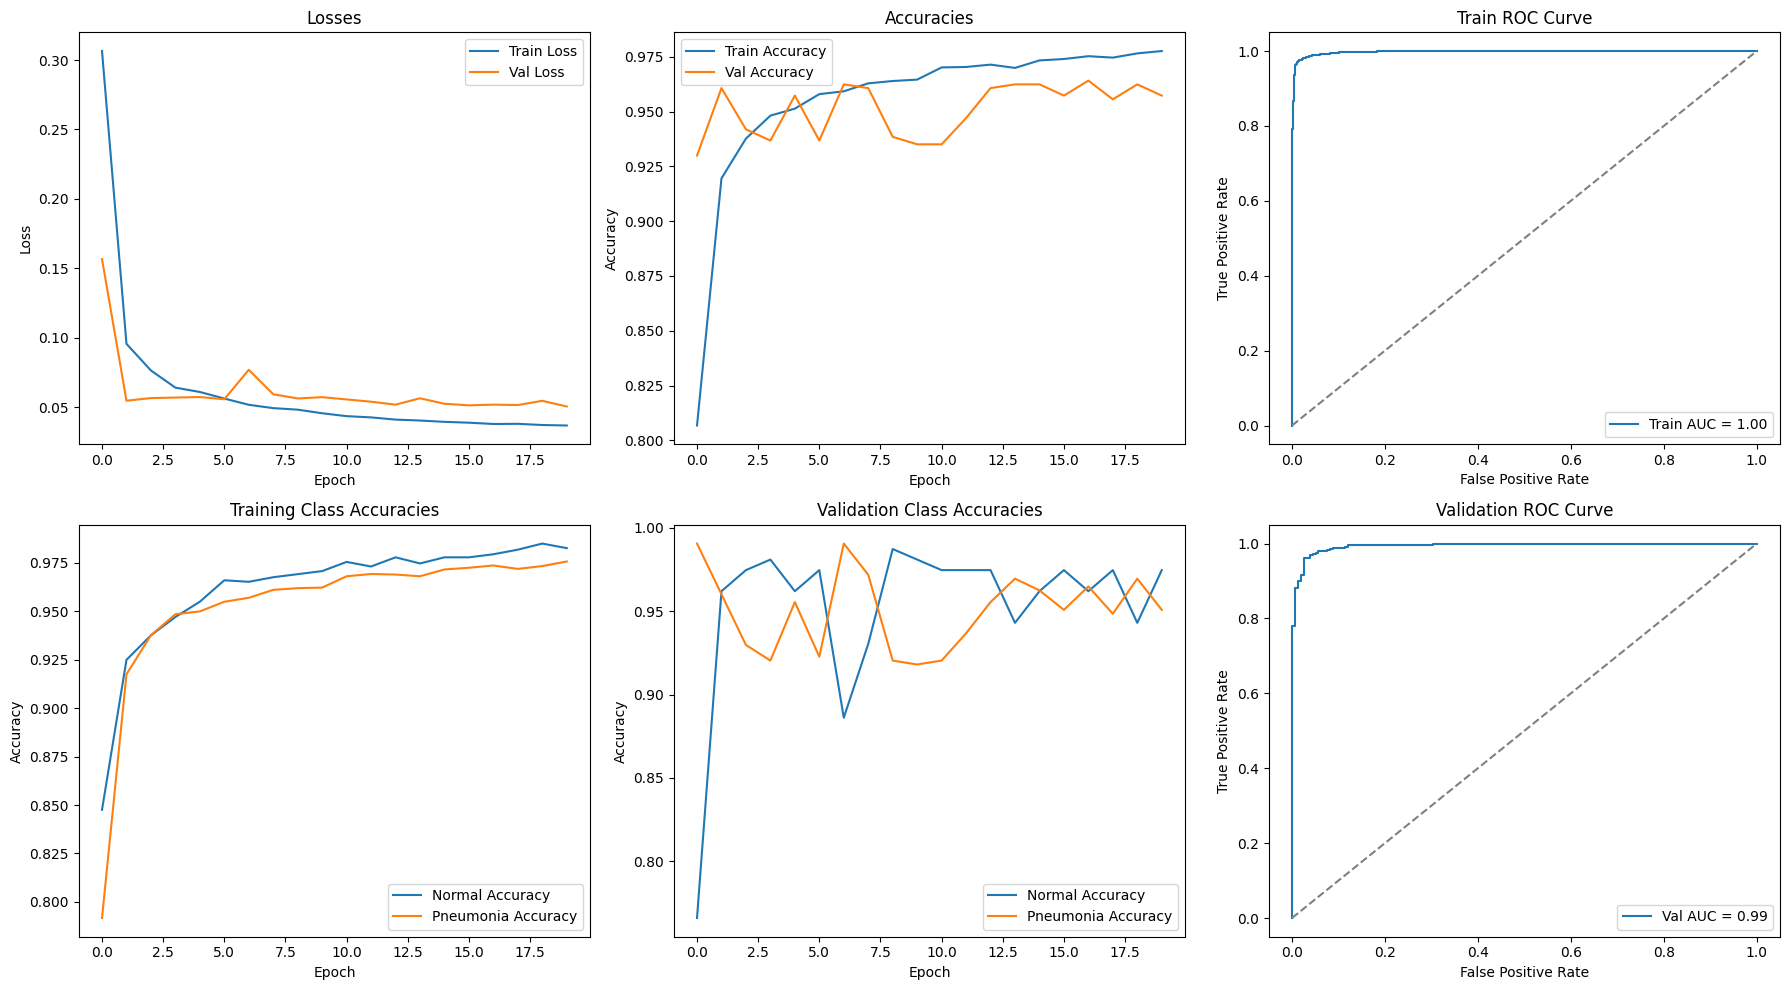

**(c)**

_Discuss your results here_

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


Epoch 20/20 - Validation: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


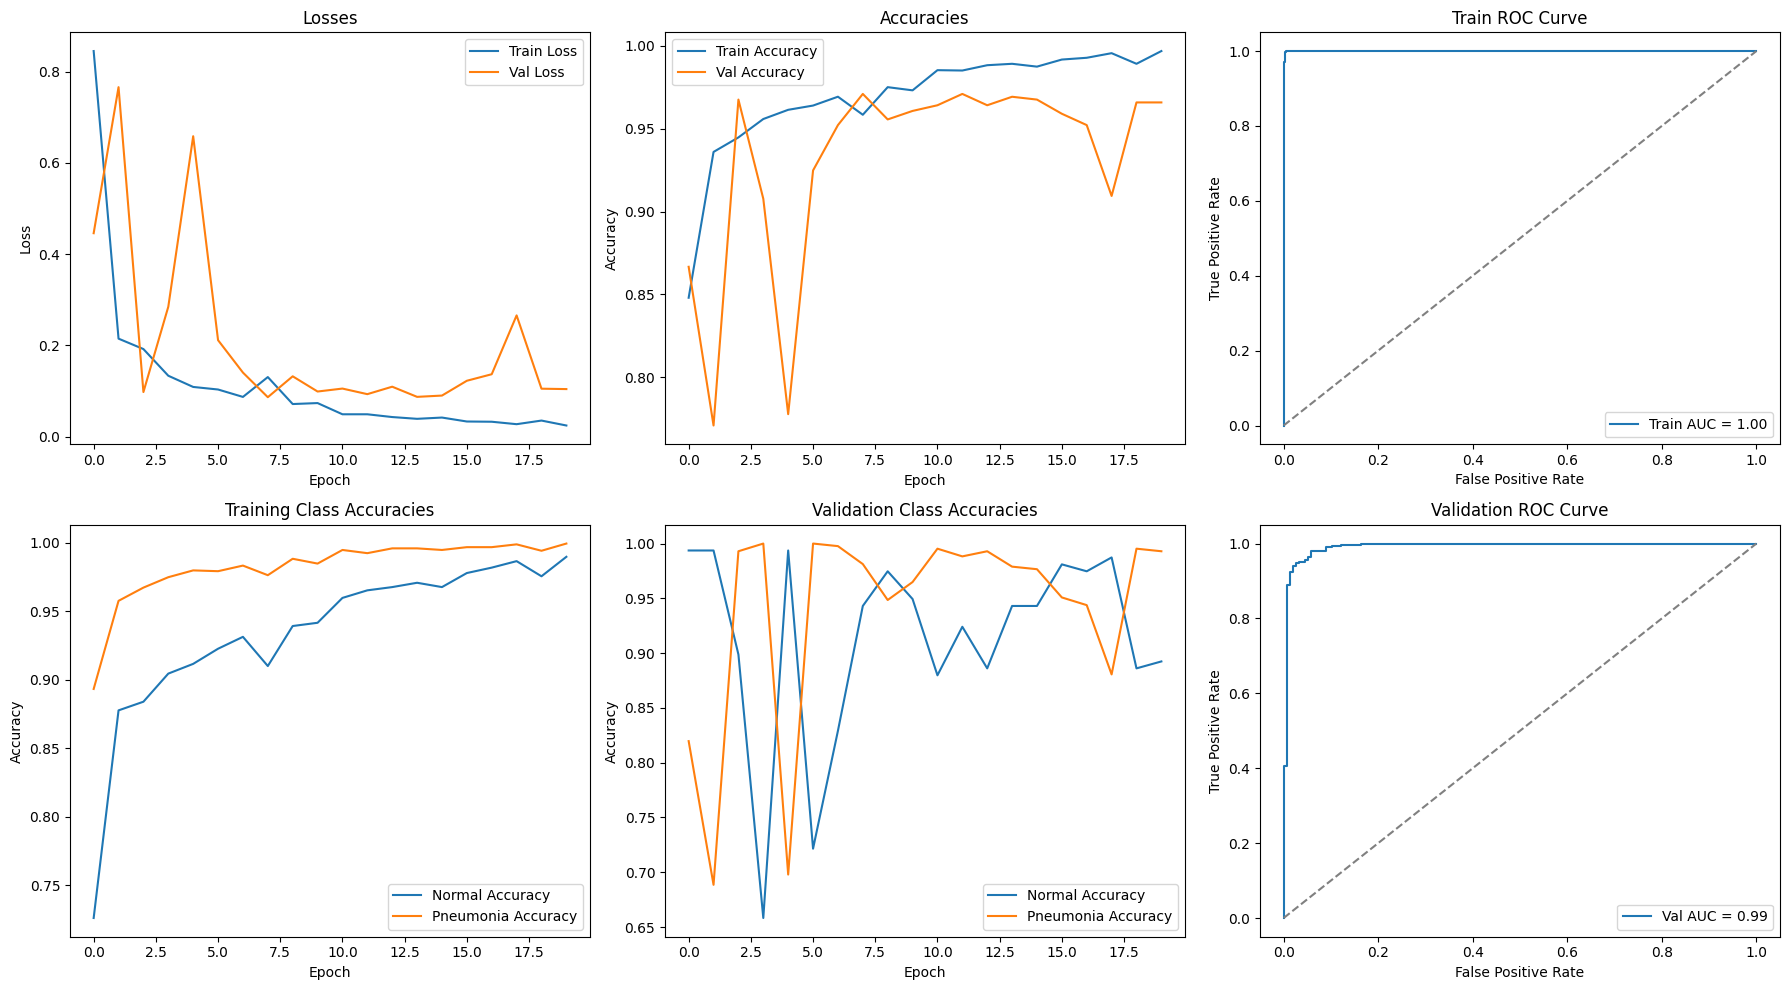

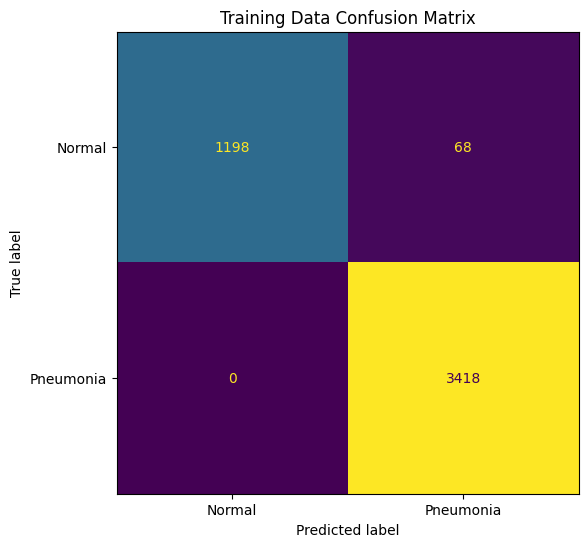

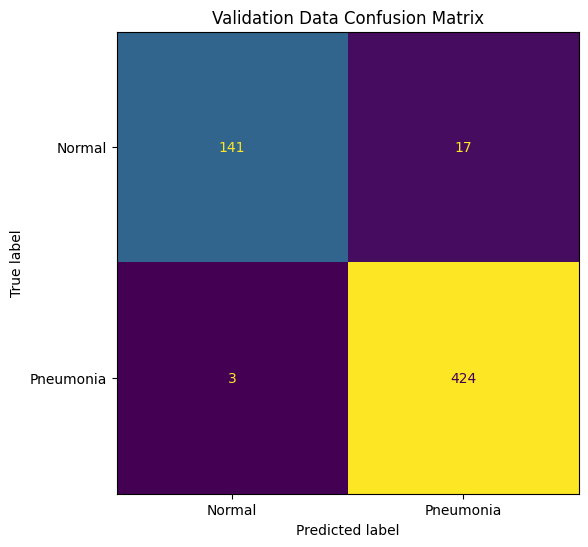

Training data: Mean:0.7525853514671326 StDev: 0.4127591550350189
Validation data: Mean:0.7548192739486694 StDev: 0.40630561113357544
Model saved as 'batchnorm_chest_xray_model.pth'


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################
# Model with batch normalization only
model = ImprovedModel().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, use_wandb = True, wandb_name='improved_chest_xray_classification_batch_norm')

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, model, train_loader, val_loader,)

# Save the model
torch.save(model.state_dict(), 'batchnorm_chest_xray_model.pth')
print("Model saved as 'batchnorm_chest_xray_model.pth'")


**(a)**

I have added batch normalization following each of the convolutional layers of the network in order to normalize activations around a mean of 0 with a standard deviation of 1.

**(b)**

Below are the results from the batch normalizaed version of the baseline model.

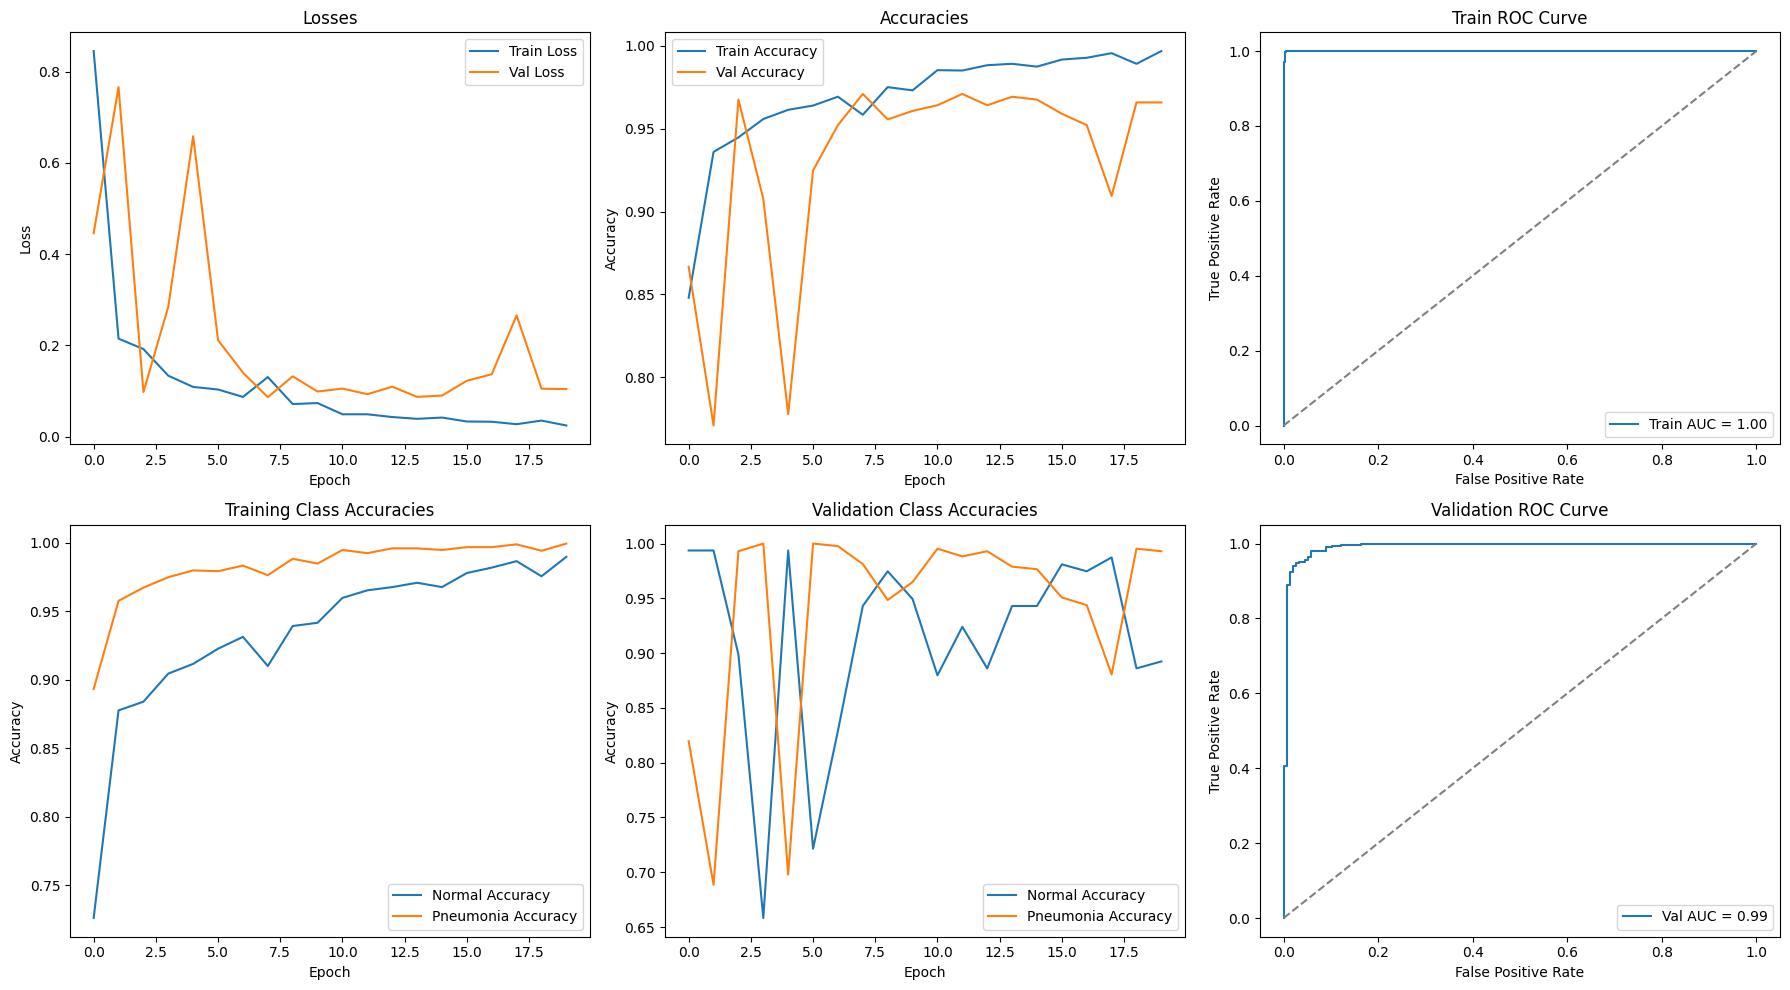

Compare these to the results of the baseline model below.

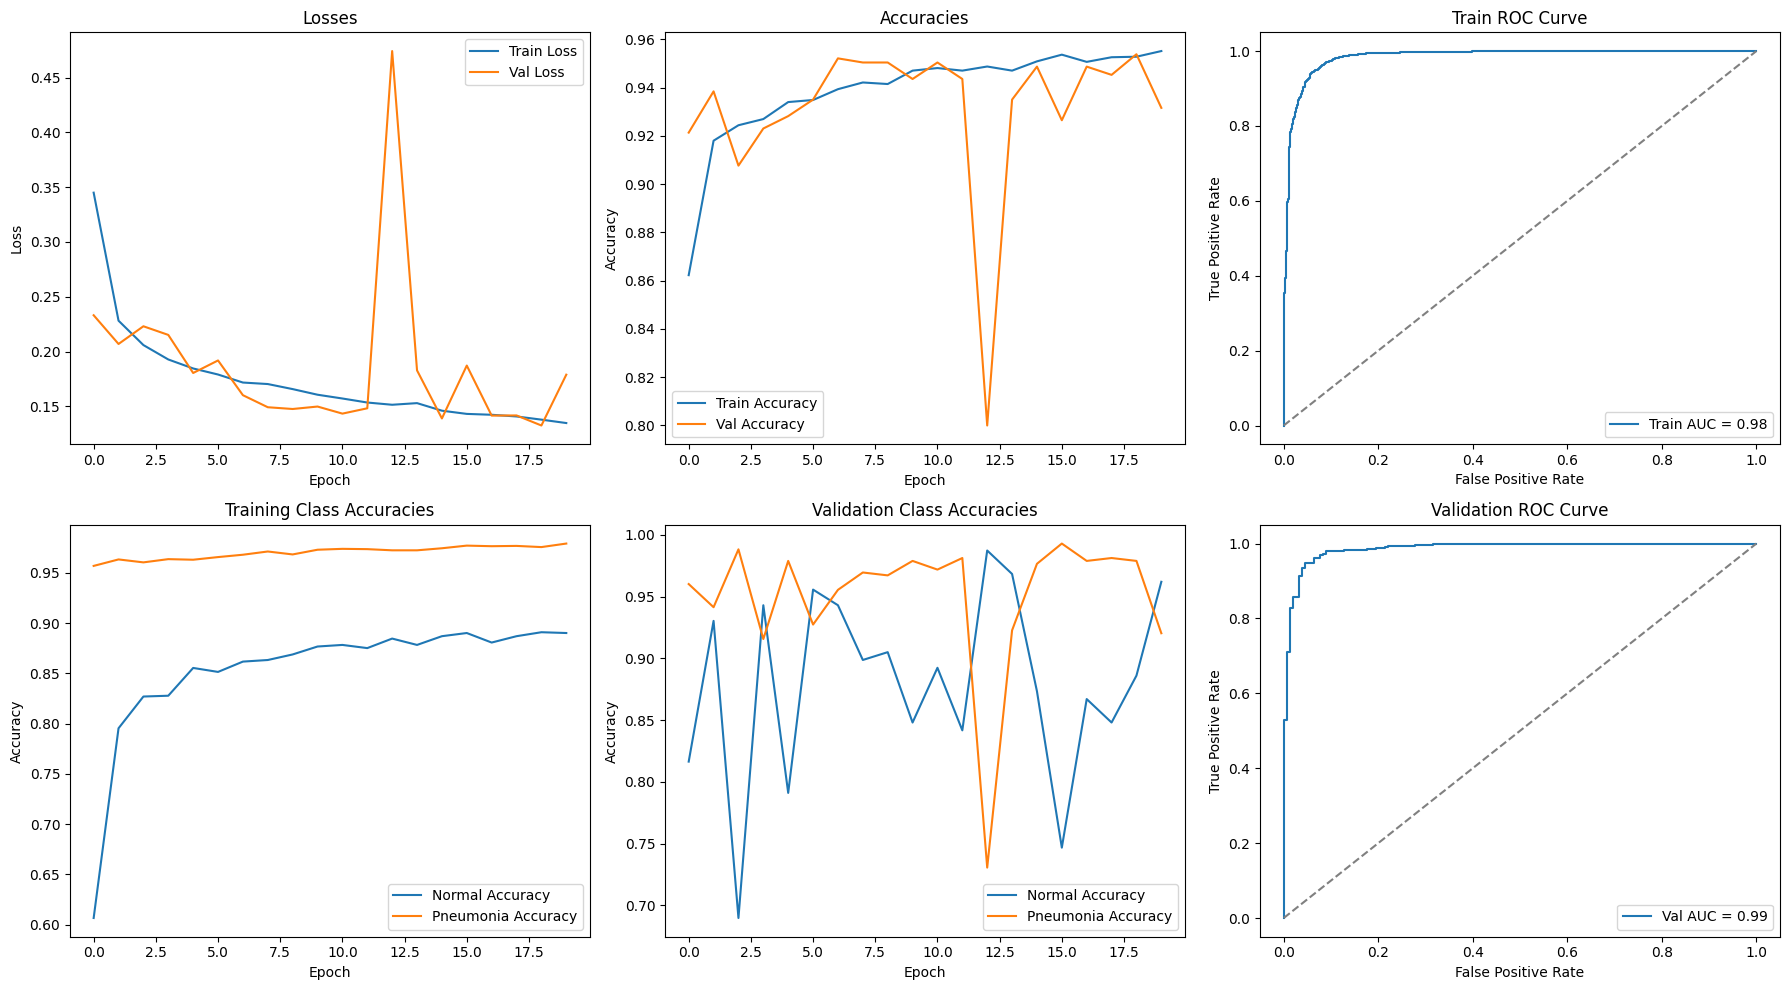

**(c)**

Batch normalization works by normalizing the input to each layer to prevent them from straying too far from a norm of 0. This is useful as it prevents too many of these values from being set to 0 by the ReLU activation function, a problem known as dead neurons, which can slow training. It also prevents explosions of weights which can lead to divergence and noisy training. As can be seen in the training graphs it was successful in this. The spikes are earlier on than they were in the simple model but the training smooths out quickly and becomes quite stable later in the training. This is especially noticable in the validation classs accuracies where training was far smoother. The model also converges much more effectively and leads to a lower final loss and a large improvement in accuracy. There is also a smaller gap between class accuracies. This is likely due to the normalization around 0 pushing outputs closer to the middle in prediction, reducing the over prediction of the positive class.

## Q 4.3: Empirically justify improvement 2 (10 marks)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 20/20 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


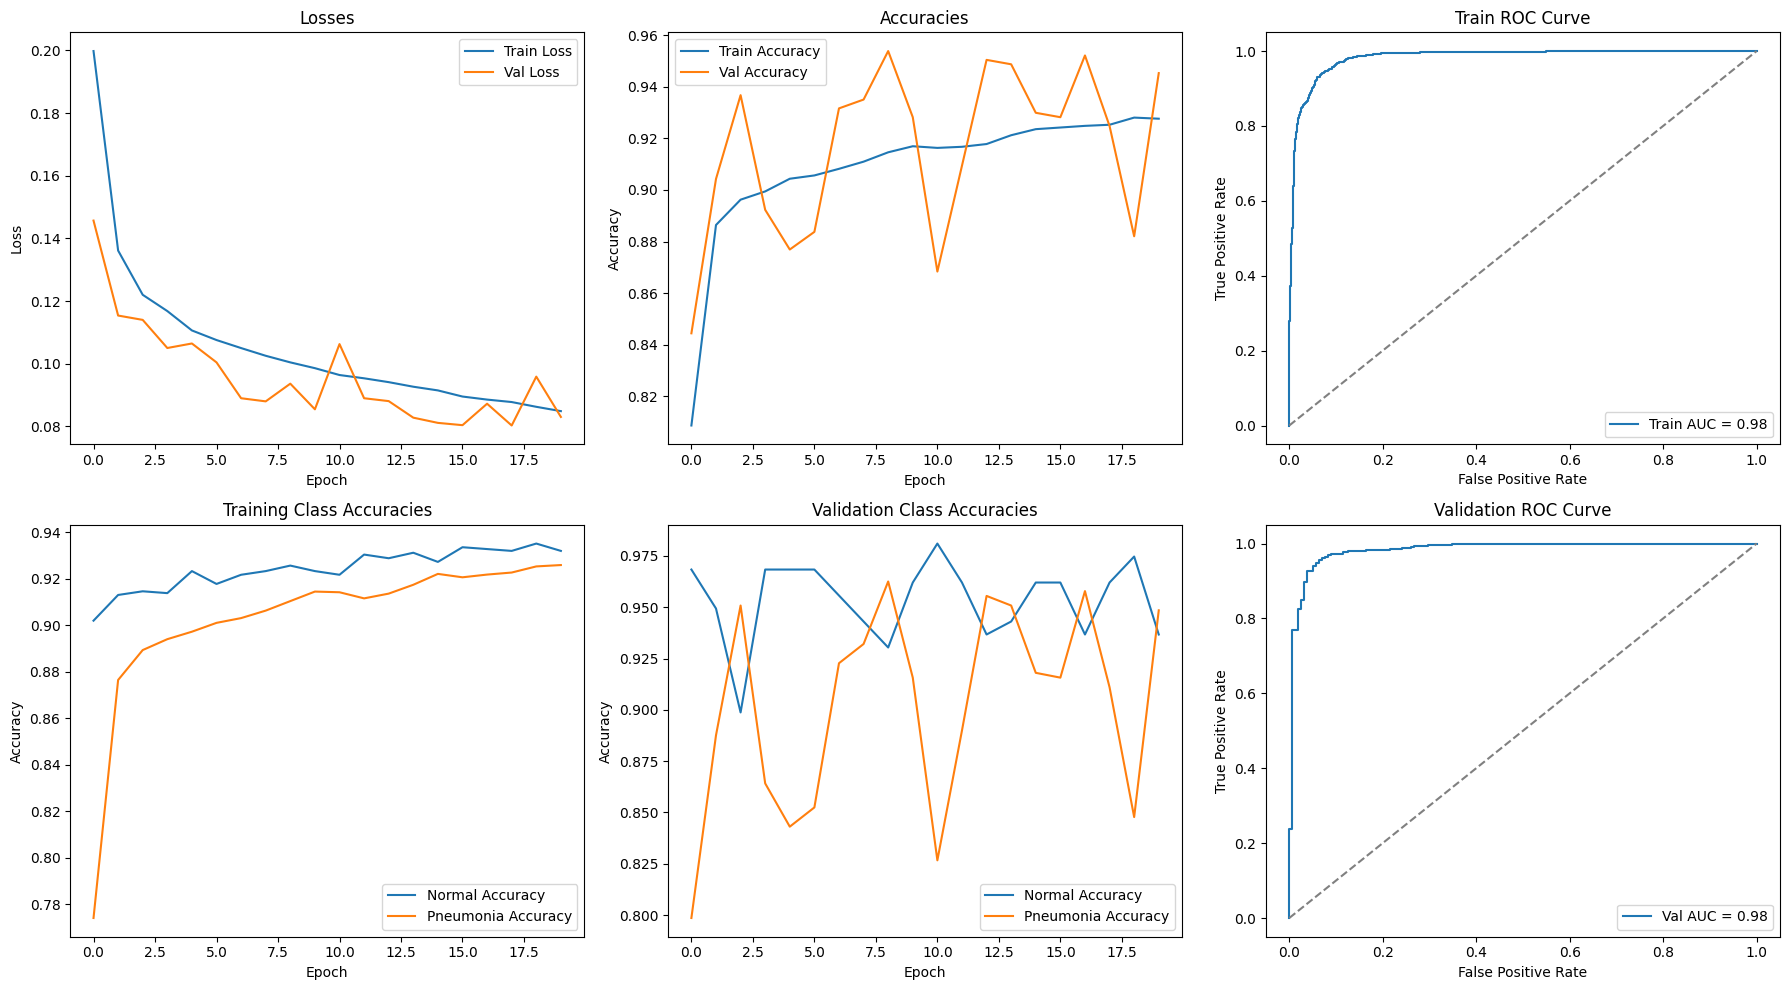

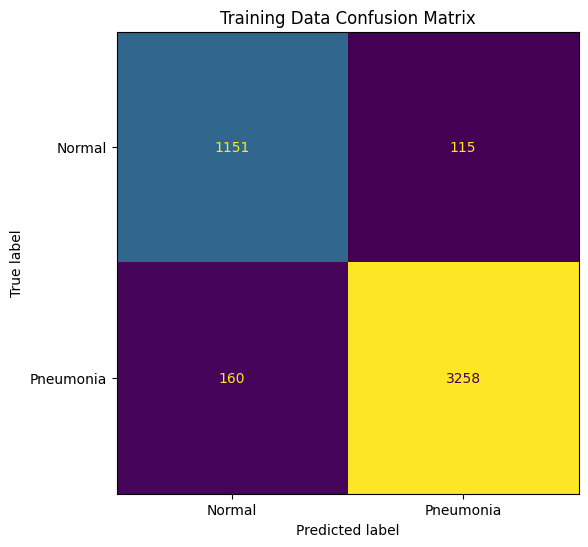

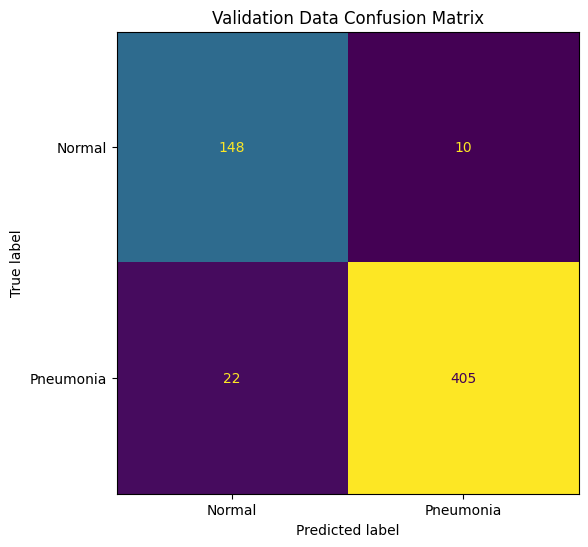

Model saved as 'loss_weight_chest_xray_model.pth'


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Model with loss weighting only
model = SimpleModel().to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.3]).to(device))

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, use_wandb = True, wandb_name='improved_chest_xray_classification_loss_weighting')

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, model, train_loader, val_loader,)

torch.save(model.state_dict(), 'loss_weight_chest_xray_model.pth')
print("Model saved as 'loss_weight_chest_xray_model.pth'")


**(a)**

Here I have used a weighting of the losses based on class size. As there are fewer instances of the normal label those are now weighed more heavily compared to pneumonia labelled losses.

**(b)**


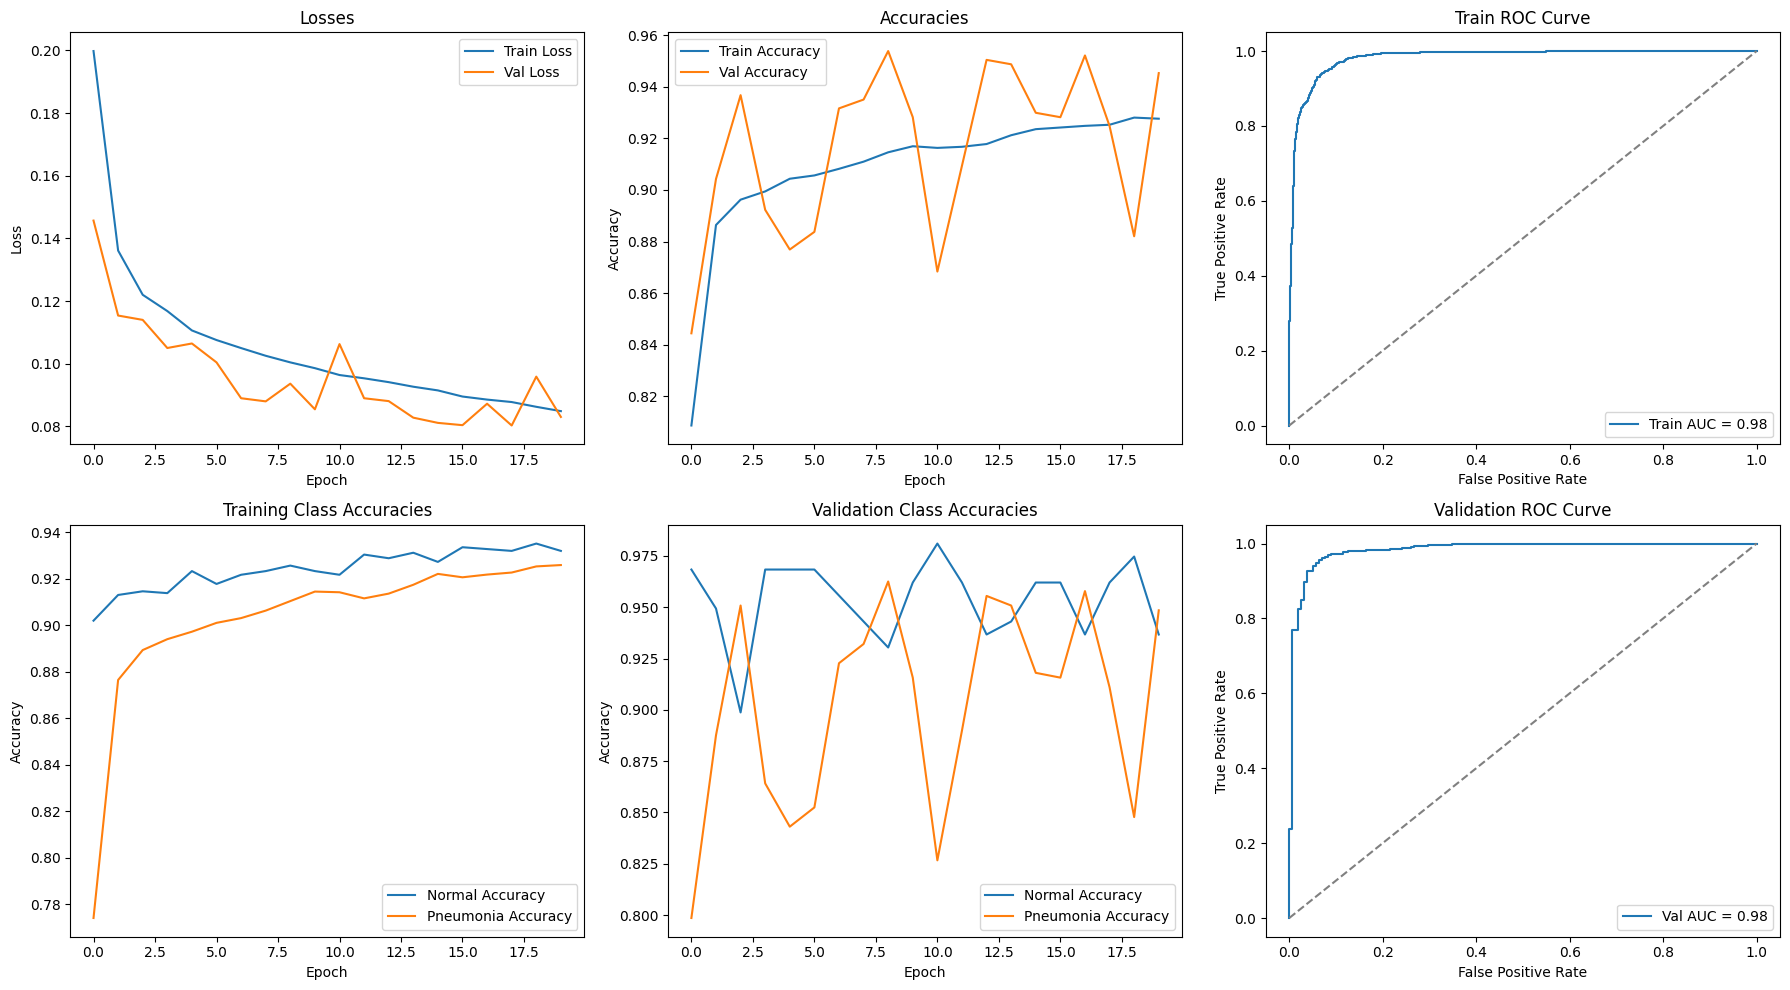

Compare the below graphs of the weighted loss version of the baseline with the same graphs in the baseline below them

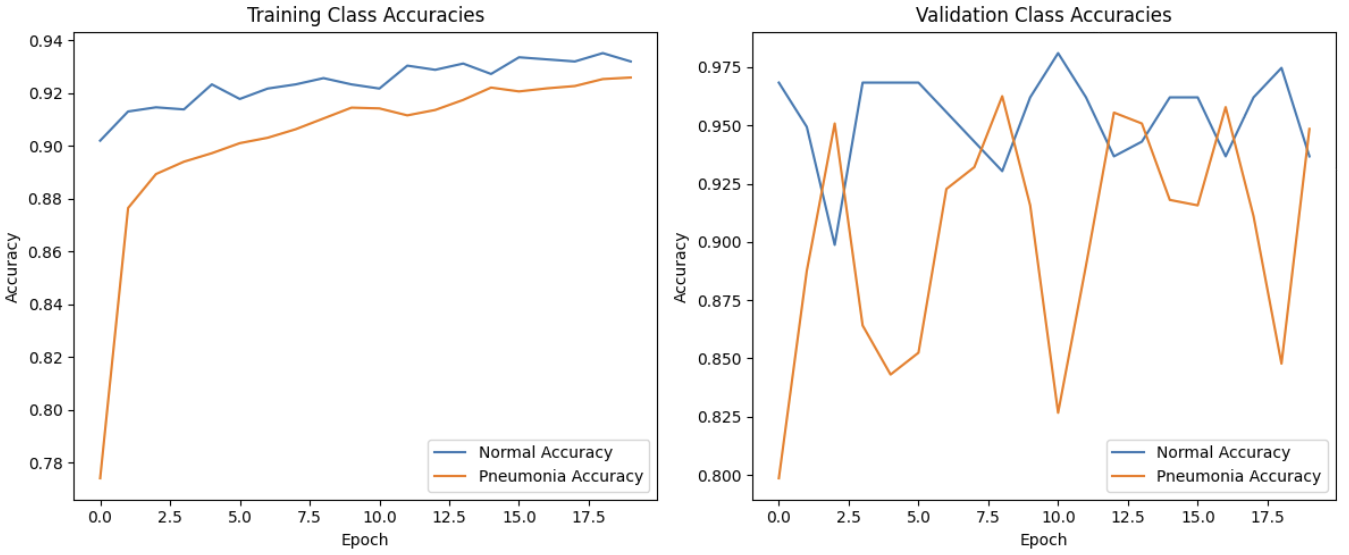

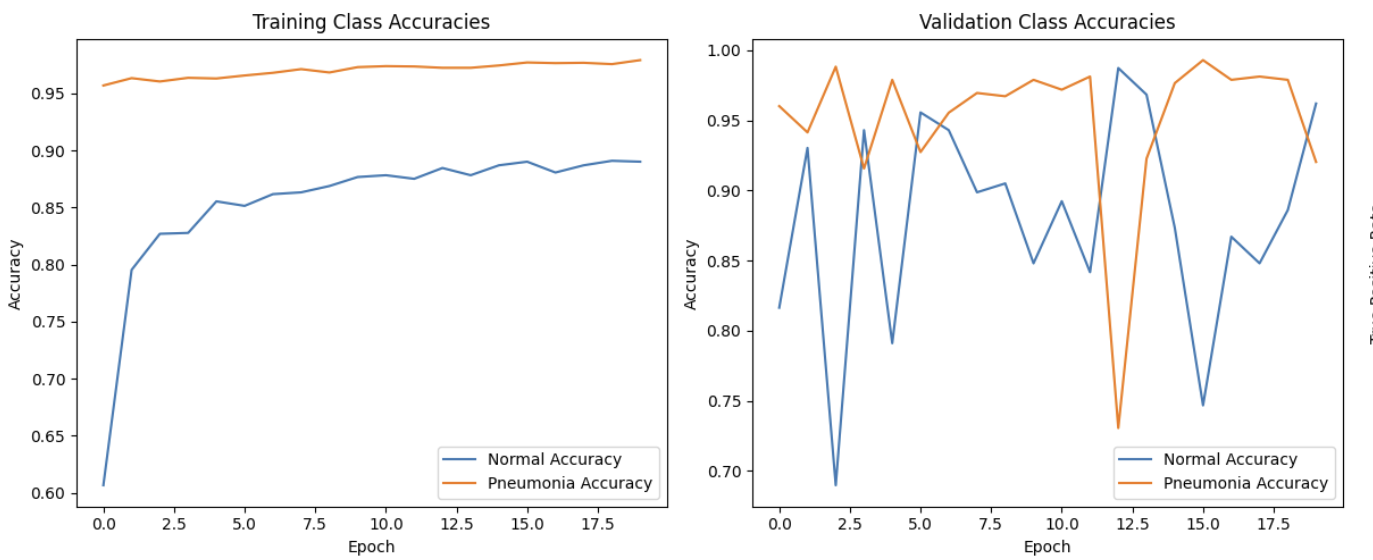

**(c)**

The class weighting was successful in closing the gap between class accuracies. As you can see in the graphs above the gap in class accuracy during training has shrunk from roughly 10% in the baseline model to 1%. When looking at validation class accuracies there was some increase in stability, the normal class accuracy was especially stable and the spikes downwards in pneumonia accuracy were only about half as large as in the baseline. There is a notable slowdown in the speed of convergence of the accuracies with the weighted loss model not reaching the same accuracy as the baseline within the 20 epochs.

## Q 4.4: Empirically justify improvement 3 (10 marks)

Epoch 20/20 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


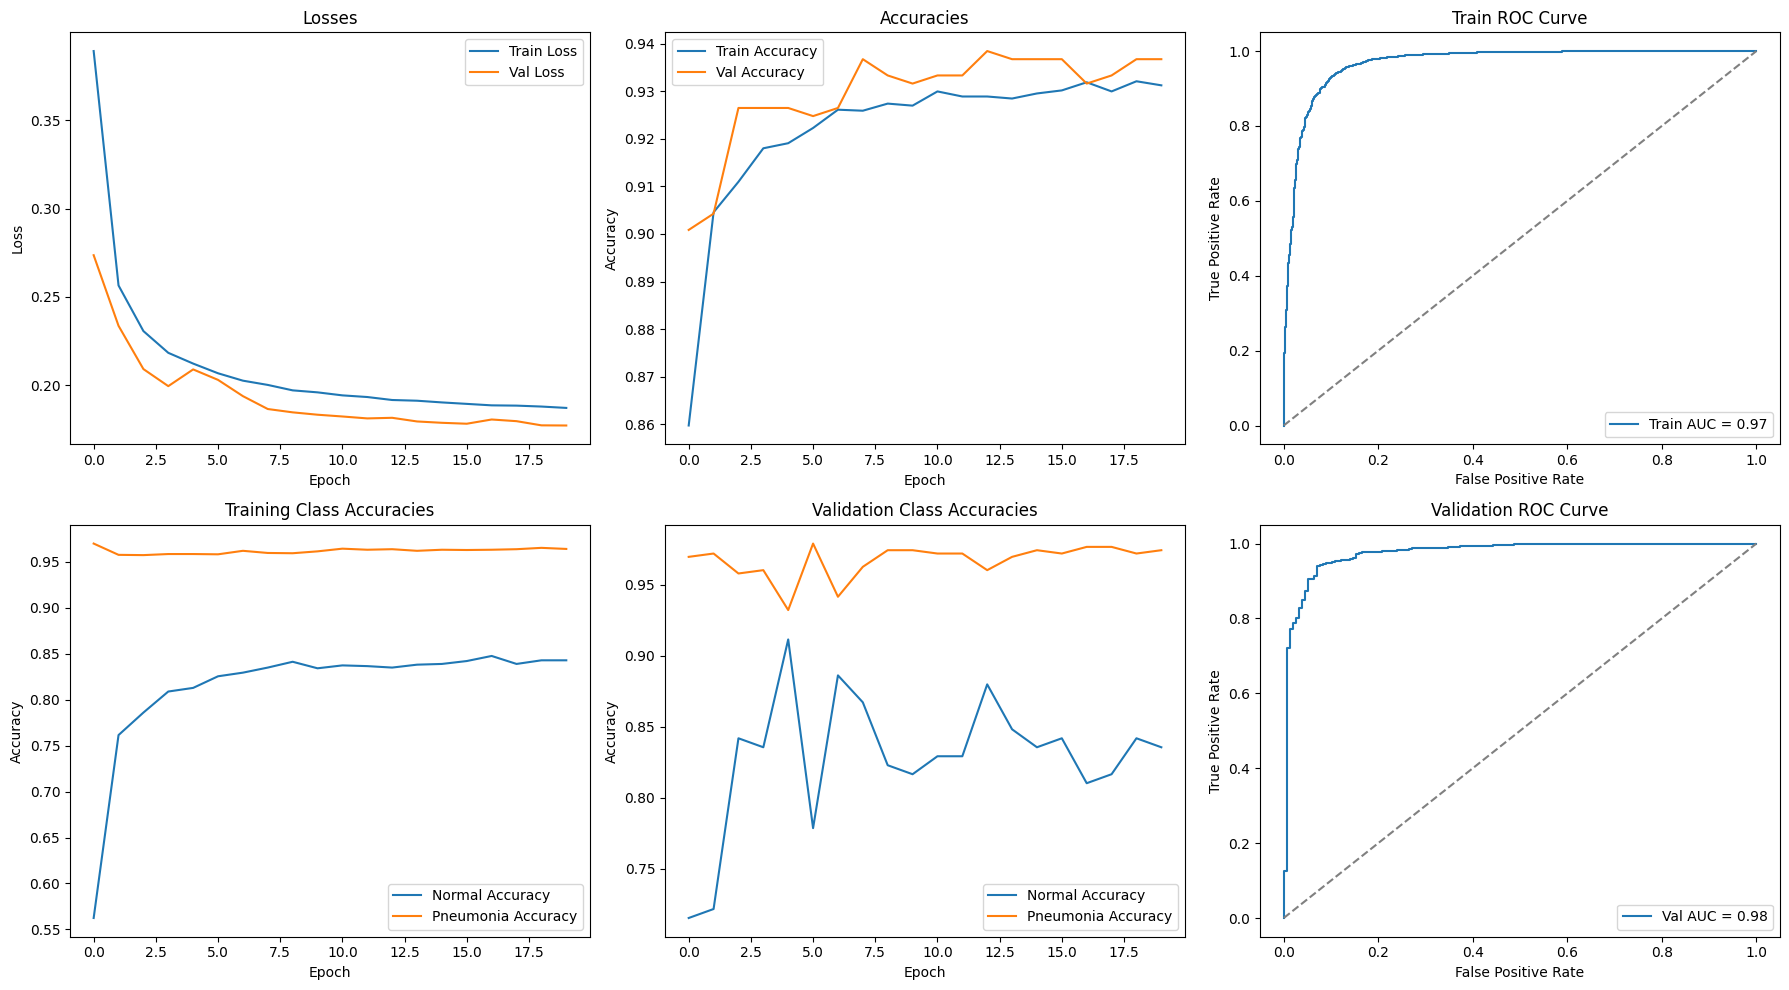

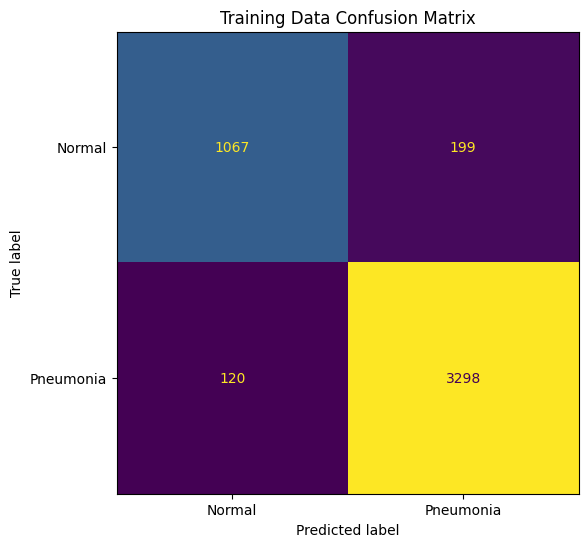

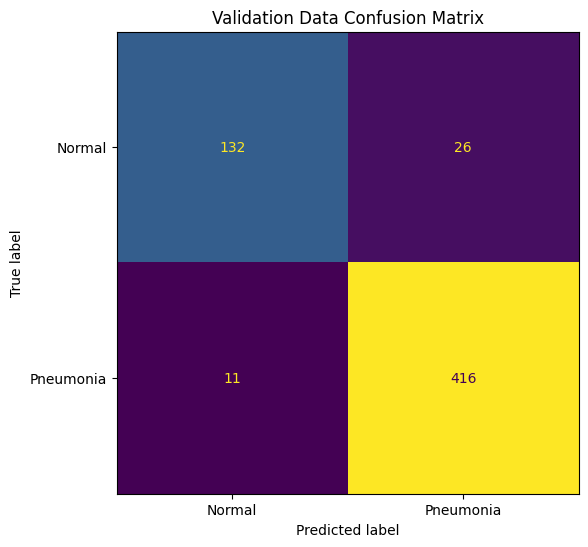

Model saved as 'lrsched_chest_xray_model.pth'


In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Model with only learning rate scheduler

model = SimpleModel().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, use_wandb = True, wandb_name='improved_chest_xray_classification_lr_scheduler', scheduler=scheduler)

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, model, train_loader, val_loader,)

torch.save(model.state_dict(), 'lrsched_chest_xray_model.pth')
print("Model saved as 'lrsched_chest_xray_model.pth'")


**(a)**

I am using a learning rate scheduler which lowers the learning rate of the optimizer throughout training.

**(b)**

Below are the graphs gathered from the learning rate scheduled baseline model.


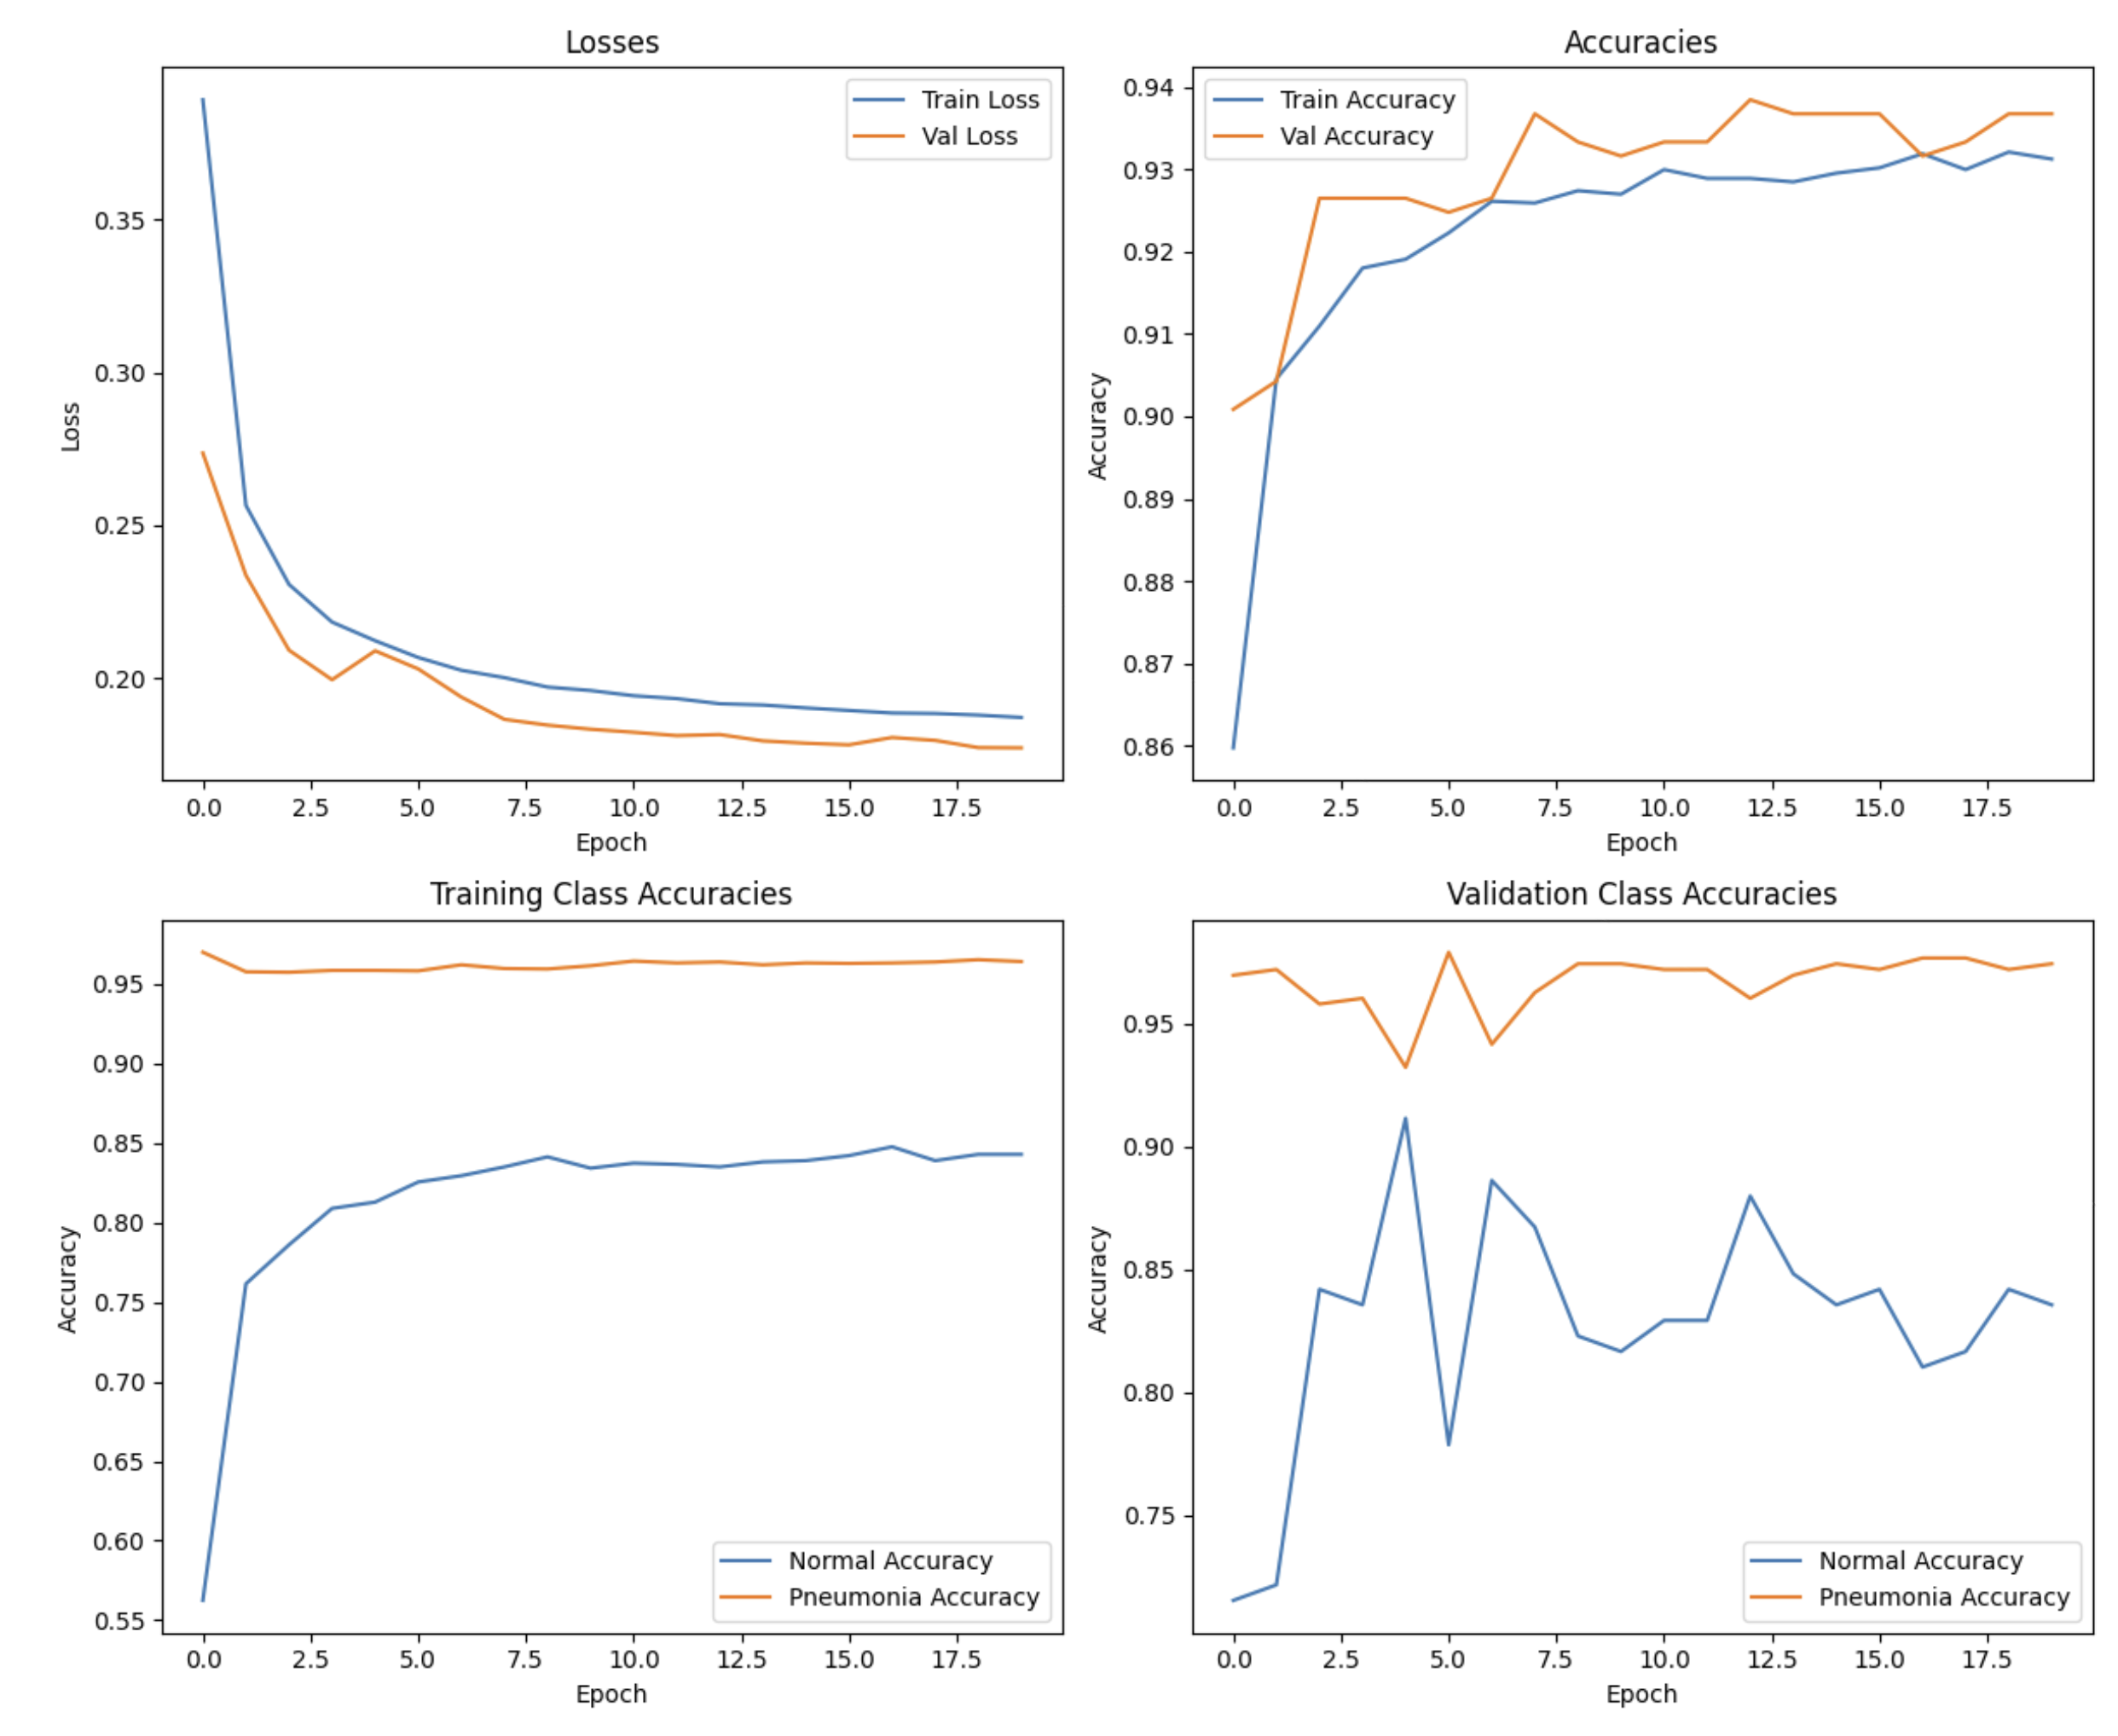

Compared to the baseline

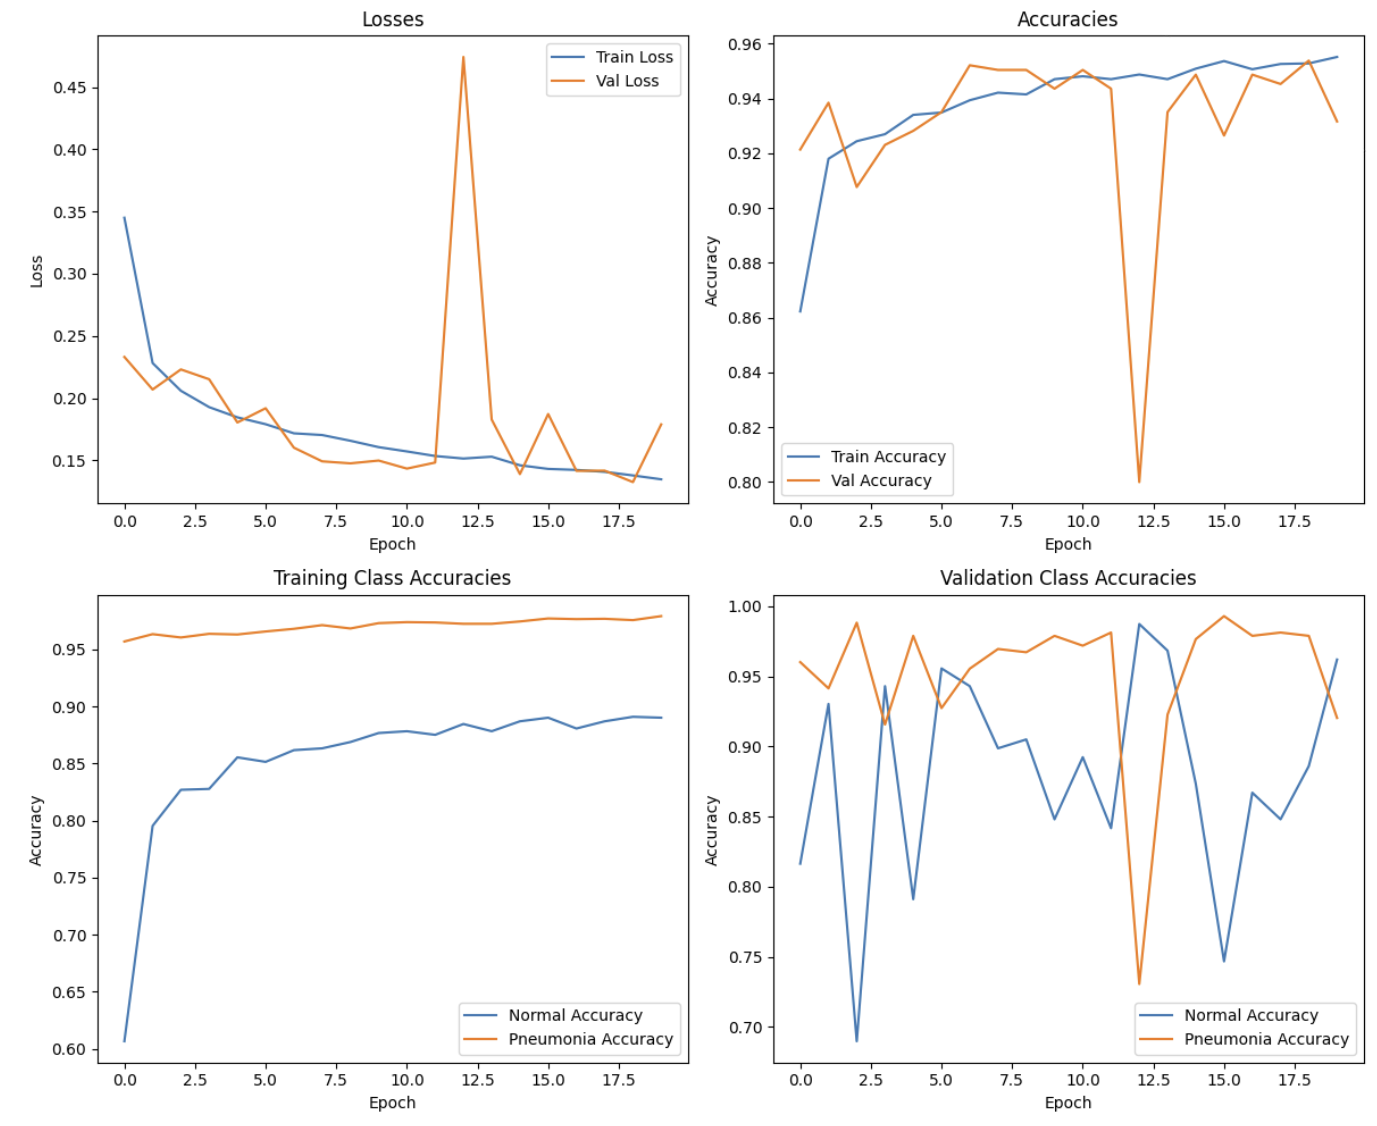

**(c)**

It is clear that the learning rate scheduler has does exactly as intended. All charts are far smoother preventing large swings in loss or accuracy that were seen in the baseline model. This does come at the expense of slower training as the model acheived training losses around 0.18 at the end of the training where the baseline had about 0.13. This is completely counteracted by the much stronger and more consistent decrease in validation loss that can be seen. This is all due to using lower learning rates as minima are approached later in

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################
# load model
model = torch.load('allimp_chest_xray_model.pth')

#evaluate model on test data
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_predictions = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        test_total += labels.size(0)
        for i in range(len(predicted)):
            if predicted[i] == labels[i]:
                test_correct += 1
        test_predictions.append(predicted)
        test_labels.append(labels)
        # Calculate test metrics
    test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_predictions = [pred for sublist in test_predictions for pred in sublist]
    test_labels = [label for sublist in test_labels for label in sublist]
    test_class_accuracy = calculate_class_accuracy(test_predictions, test_labels)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Class Accuracy: {test_class_accuracy}")

<ipython-input-32-85af701991b2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('allimp_chest_xray_model.pth')


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

**(a)**

_Present your results, including plots etc, here_

**(b)**

_Discuss your results here_